# Projet apartment hunter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import prediction_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_csv("houses_Madrid.csv")
df = df.drop('Unnamed: 0',axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   16277 non-null  object 
 12  is_exact_address_hidden       21742 non-null  bool   
 13  s

## Nettoyage des données

In [5]:
df.describe()

,id,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,longitude,portal,door,rent_price,rent_price_by_area,buy_price,buy_price_by_area,built_year,are_pets_allowed,is_furnished,is_kitchen_equipped,has_private_parking,has_public_parking,parking_price
count,21742.00,21616.00,8228.00,21742.00,21726.00,1437.00,1432.00,0.00,0.00,0.00,0.00,21742.00,0.00,21742.00,21742.00,10000.00,0.00,0.00,0.00,0.00,0.00,7719.00
mean,10871.50,146.92,103.46,3.01,2.09,3.13,241.69,NaN,NaN,NaN,NaN,-59170.31,NaN,653735.65,4020.52,1970.05,NaN,NaN,NaN,NaN,NaN,2658.00
std,6276.52,134.18,88.26,1.51,1.41,0.91,247.48,NaN,NaN,NaN,NaN,917116.18,NaN,782082.07,1908.42,69.39,NaN,NaN,NaN,NaN,NaN,13360.97
min,1.00,13.00,1.00,0.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,-34590276.00,NaN,36000.00,447.00,1723.00,NaN,NaN,NaN,NaN,NaN,0.00
25%,5436.25,70.00,59.00,2.00,1.00,2.00,2.00,NaN,NaN,NaN,NaN,725.00,NaN,198000.00,2551.00,1957.00,NaN,NaN,NaN,NaN,NaN,0.00
50%,10871.50,100.00,79.00,3.00,2.00,3.00,232.00,NaN,NaN,NaN,NaN,1116.00,NaN,375000.00,3720.00,1970.00,NaN,NaN,NaN,NaN,NaN,0.00
75%,16306.75,162.00,113.00,4.00,2.00,4.00,354.00,NaN,NaN,NaN,NaN,1687.00,NaN,763600.00,5000.00,1994.00,NaN,NaN,NaN,NaN,NaN,0.00
max,21742.00,999.00,998.00,24.00,16.00,7.00,997.00,NaN,NaN,NaN,NaN,2517.00,NaN,8800000.00,18889.00,8170.00,NaN,NaN,NaN,NaN,NaN,600000.00


## Doublons

In [6]:
df['id'].duplicated().value_counts()

id
False    21742
Name: count, dtype: int64

In [7]:
df.duplicated().value_counts()

False    21742
Name: count, dtype: int64

Le jeu de données ne semble pas contenir de doublons.

## Valeurs manquantes

<Axes: >

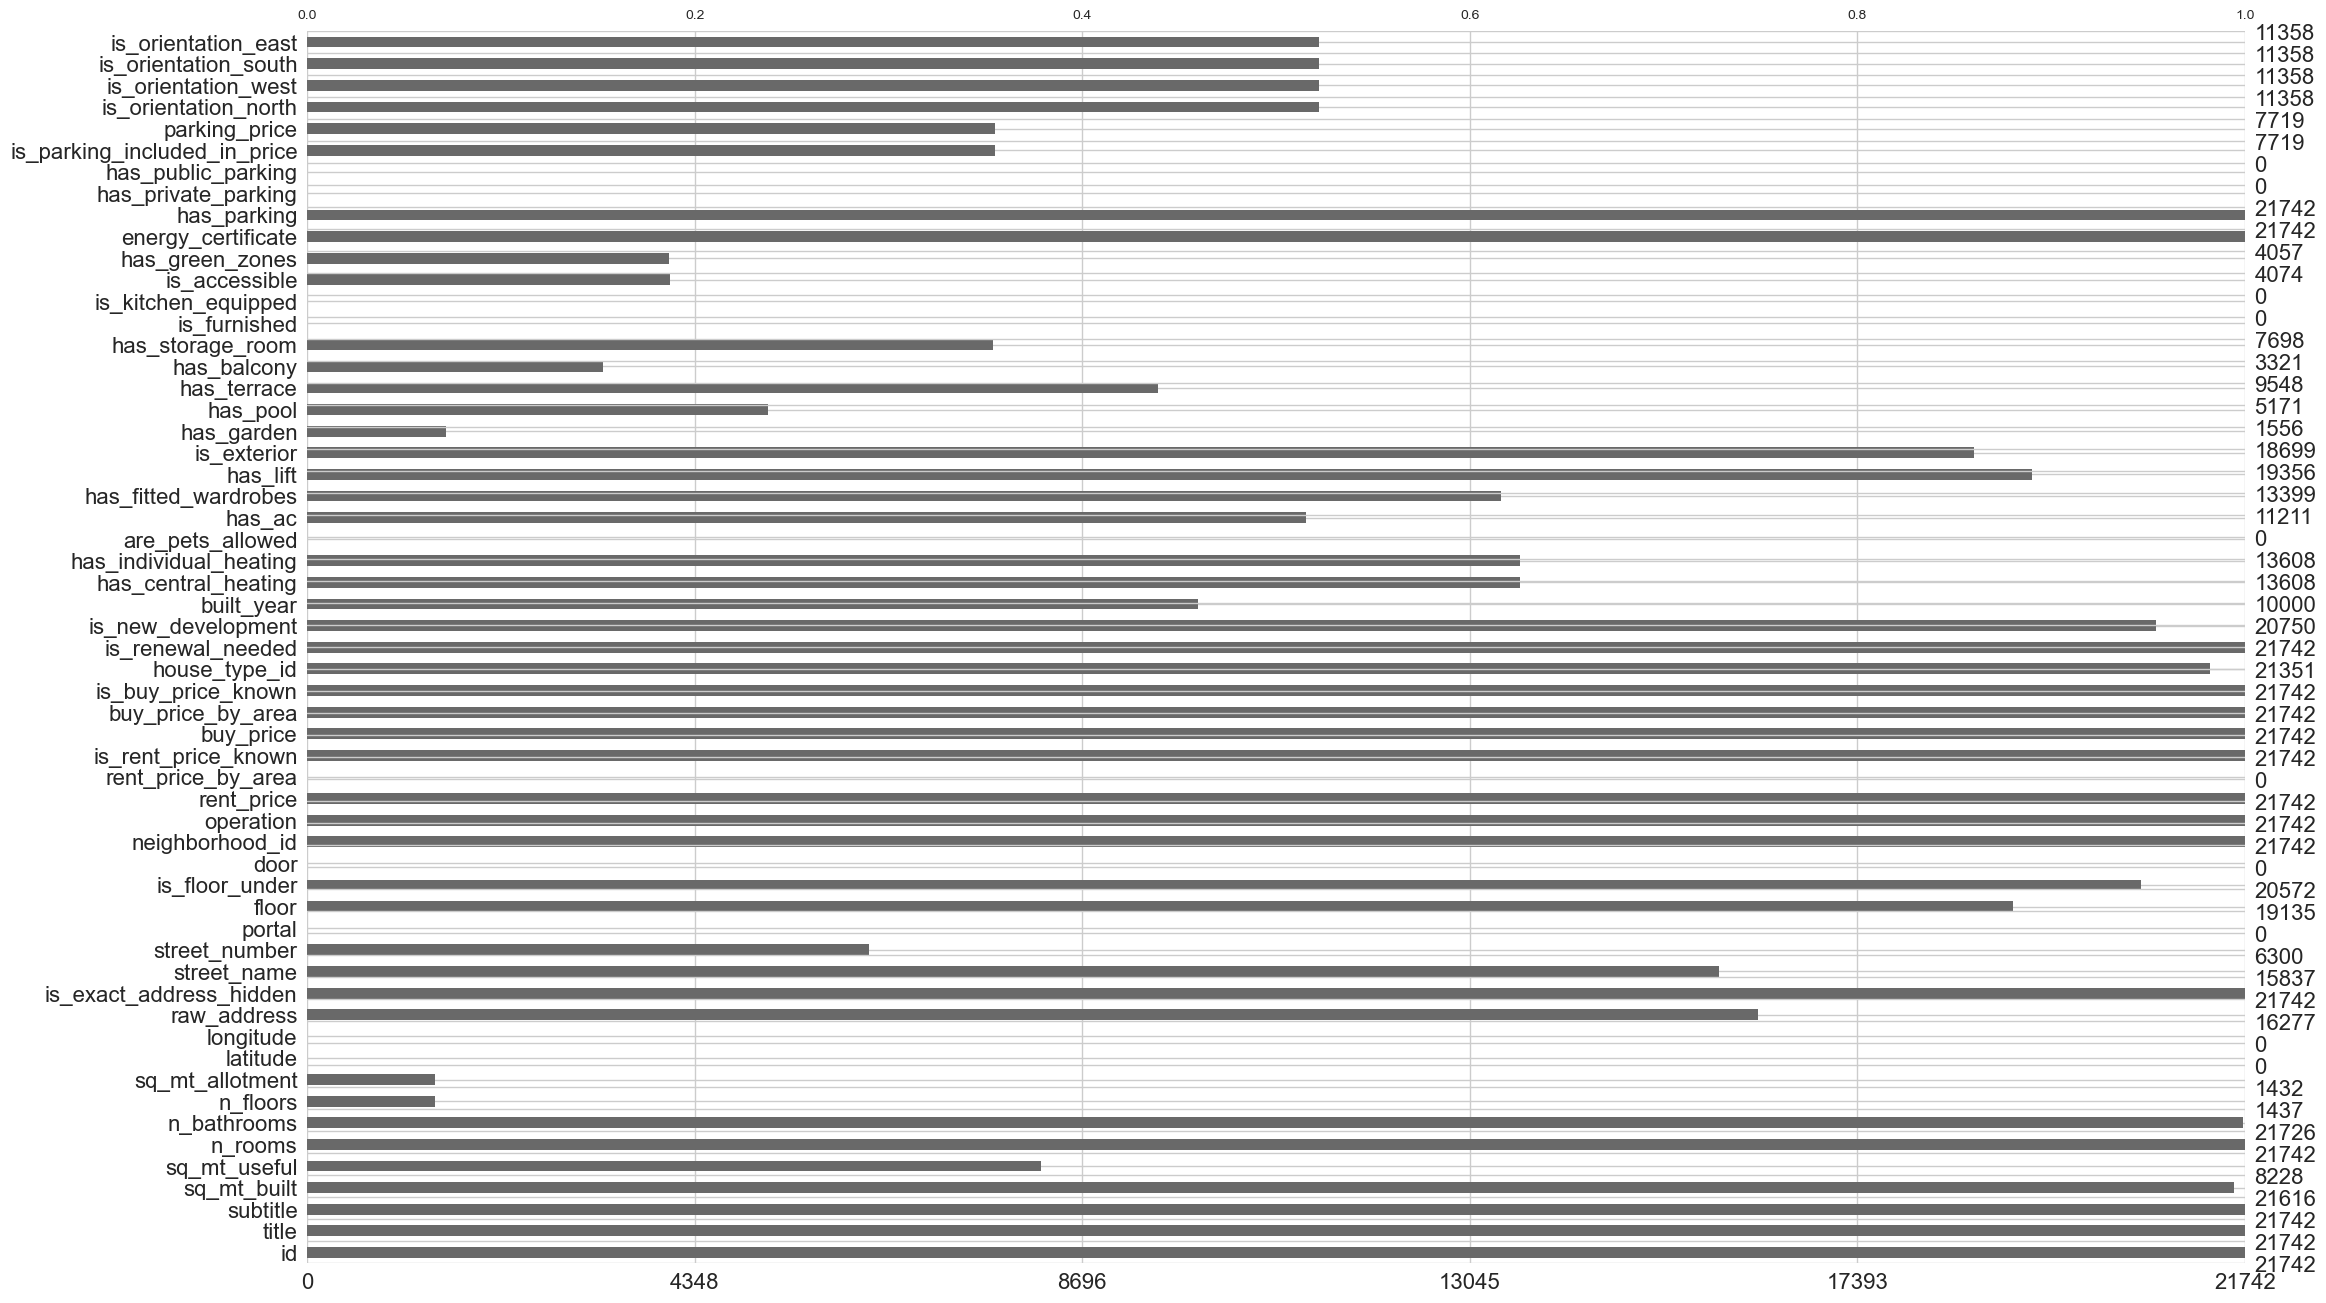

In [8]:
msno.bar(df)

Plusieurs colonnes sont vides, je commence par les supprimer.

In [9]:
df = df.dropna(axis=1, how='all')

<Axes: >

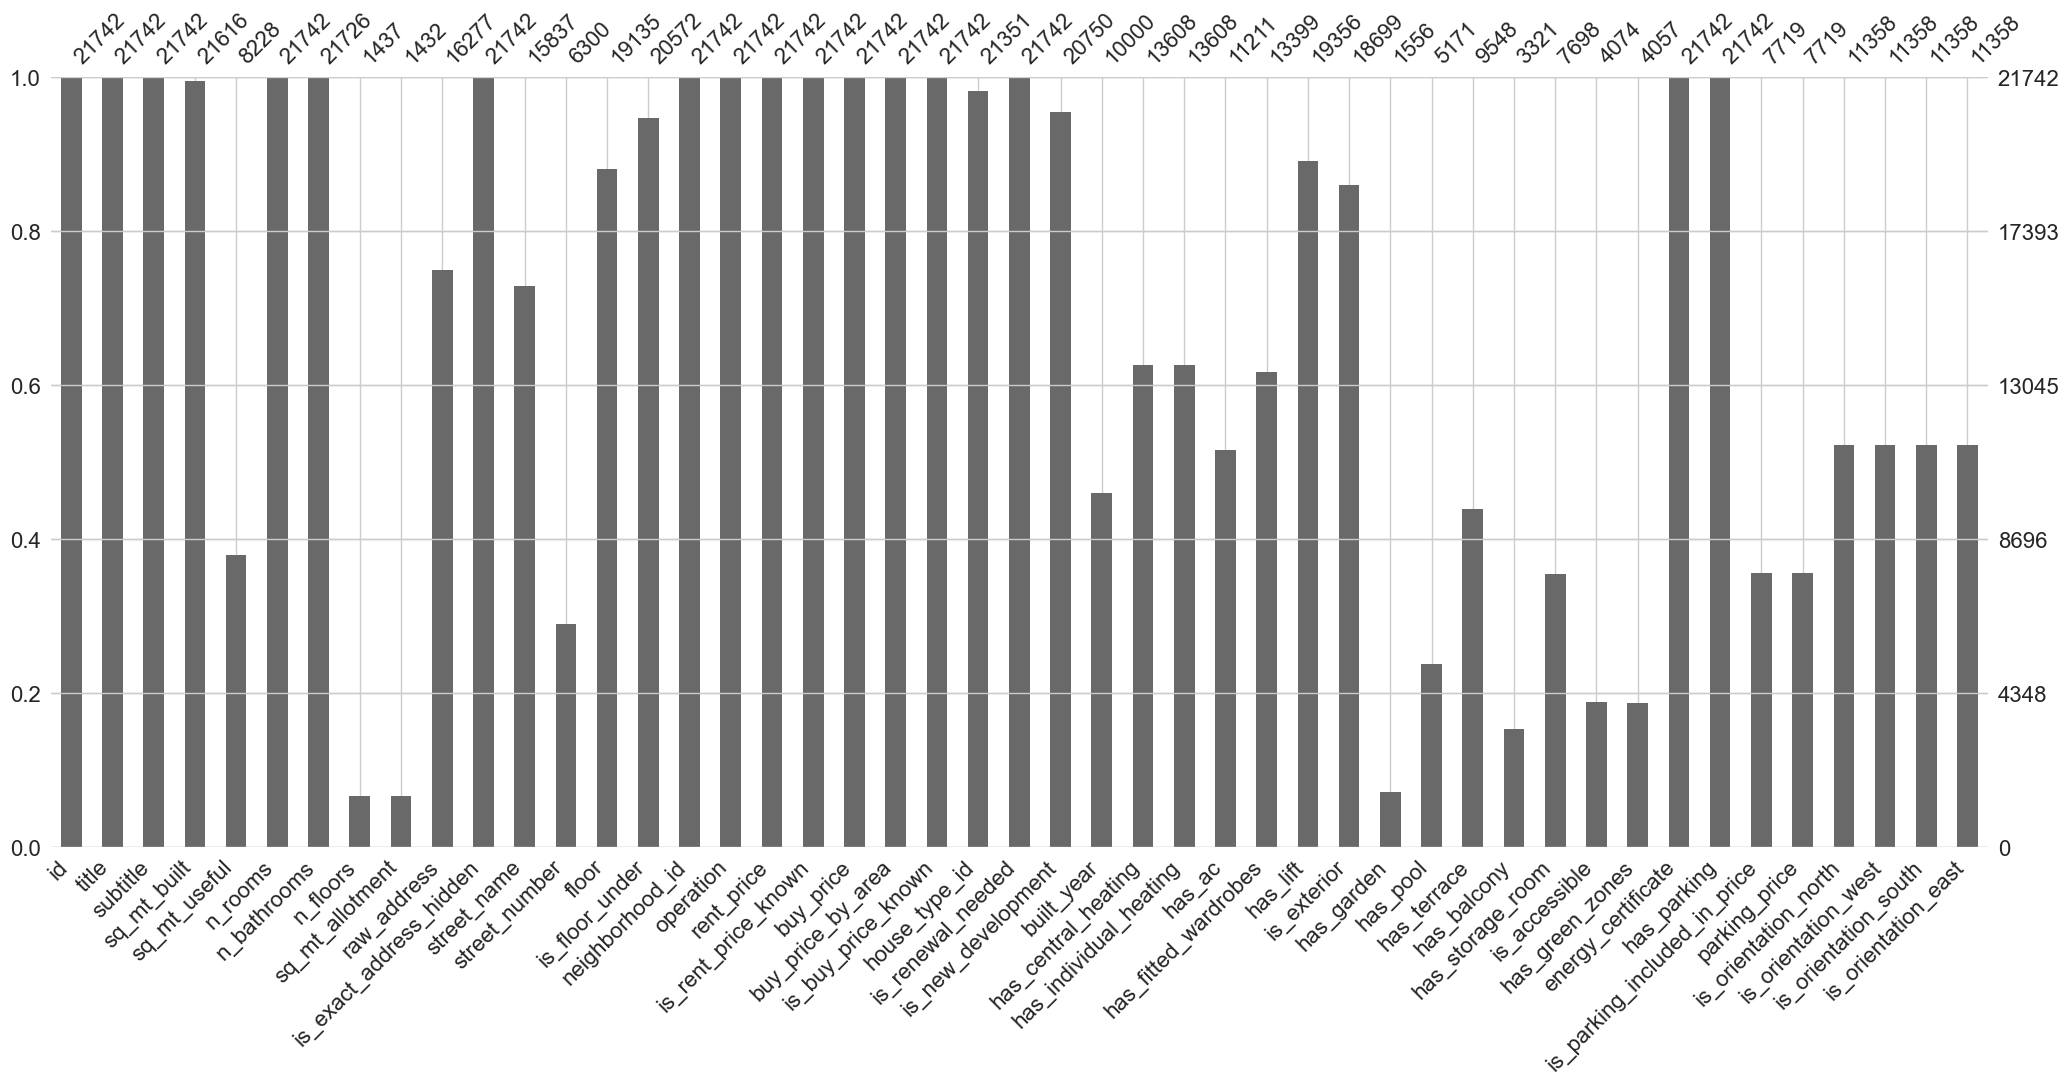

In [10]:
msno.bar(df)

Après avoir retirer les colonnes vides, analysons nos colonnes:  
* id : identifiant de la vente
* title : titre de l'annonce
* subtitle : sous-titre de l'annonce
* sq_mt_built : surface bâtie (mètre carré)
* sq_mt_useful : surface habitable (mètre carré)
* n_rooms : nombre de pièce
* n_bathrooms : nombre de salle de bain
* n_floors : nombre d'étages
* sq_mt_allotment : lotissement (mètre carré)
* raw_address : adresse
* is_exact_address_hidden : adresse correcte (True / False)
* street_name : nom de la rue
* street_number : numéro de rue
* floor : Etage
* is_floor_under : contient un sous-sol
* neighborhood_id : identifiant du quartier
* operation : type de transaction (une valeur : vente )
* rent_price : prix de location 
* is_rent_price_known : prix de location connu (True / False)
* buy_price : prix d'achat
* buy_price_by_area : prix d'achat par mètre carré
* is_buy_price_known : prix d'achat connu (True / False)
* house_type_id : identifiant du type de maison
* is_renewal_needed : travaux nécessaire (True / False)
* built_year : année de construction
* has_central_heating : comprend un chauffage central
* has_individual_heating : comprend un chauffage individuel
* has_ac : comprend un climatiseur
* has_fitted_wardrobes : comprend des placards
* has_lift : comprend un ascenseur
* is_exterior : comprend un extérieur
* has_garden : comprend un jardin
* has_pool : comprend une piscine
* has_terrace : comprend une terrasse
* has_balcony : comprend un balcon
* has_storage_room : comprend un cagibi
* is_accessible : est accessible (moyens de transport ?)
* has_green_zones : comprend des espaces verts
* energy_certificate : certificat d'économie d'énergie
* has_parking : comprend un parking
* is_parking_included_in_price : prix du parking inclue dans le prix
* parking_price : prix du parking
* is_orientation_north : orientation nord
* is_orientation_west : orientation ouest
* is_orientation_south : orientation sud
* is_orientation_east : orientation est.

In [11]:
df.dtypes.value_counts()

object     30
float64     7
int64       5
bool        5
Name: count, dtype: int64

Plusieurs colonnes sont de type object alors qu'elles devraient être au format bool.

In [12]:
columns_is_bol = df.filter(regex='^is|^has')
columns_is_bol = columns_is_bol.astype(bool)

In [13]:
df.dtypes.value_counts()

object     30
float64     7
int64       5
bool        5
Name: count, dtype: int64

## Imputation des valeurs manquantes des variables catégorielles.

In [14]:
for col in df.select_dtypes(include=['bool','object']):
    print('Colonne :',col)
    print('Valeurs manquantes :',df[col].isna().sum())
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print('* *'*20)

Colonne : title
Valeurs manquantes : 0
['Piso en venta en calle de Godella, 64'
 'Piso en venta en calle de la del Manojo de Rosas'
 'Piso en venta en calle del Talco, 68'
 'Piso en venta en calle Pedro Jiménez'
 'Piso en venta en carretera de Villaverde a Vallecas']
10736
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
Colonne : subtitle
Valeurs manquantes : 0
['San Cristóbal, Madrid' 'Los Ángeles, Madrid' 'San Andrés, Madrid'
 'Los Rosales, Madrid' 'Villaverde, Madrid']
146
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
Colonne : raw_address
Valeurs manquantes : 5465
['Calle de Godella, 64' 'Calle de la del Manojo de Rosas'
 'Calle del Talco, 68' 'Calle Pedro Jiménez'
 'Carretera de Villaverde a Vallecas']
9666
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
Colonne : is_exact_address_hidden
Valeurs manquantes : 0
[False  True]
2
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
Colonne : street_name
Valeurs manquantes : 5905
['Calle

Plusieurs colonnes booléennes ne contiennent qu'une seule valeur (True ou False).

In [15]:
colonne_has = ['has_garden','has_pool','has_terrace','has_balcony','has_storage_room','has_green_zones']
df[colonne_has] = df[colonne_has].apply(lambda col: col.fillna(False) if col.all() else col.fillna(True) if not col.any() else col, axis=0)


<Axes: >

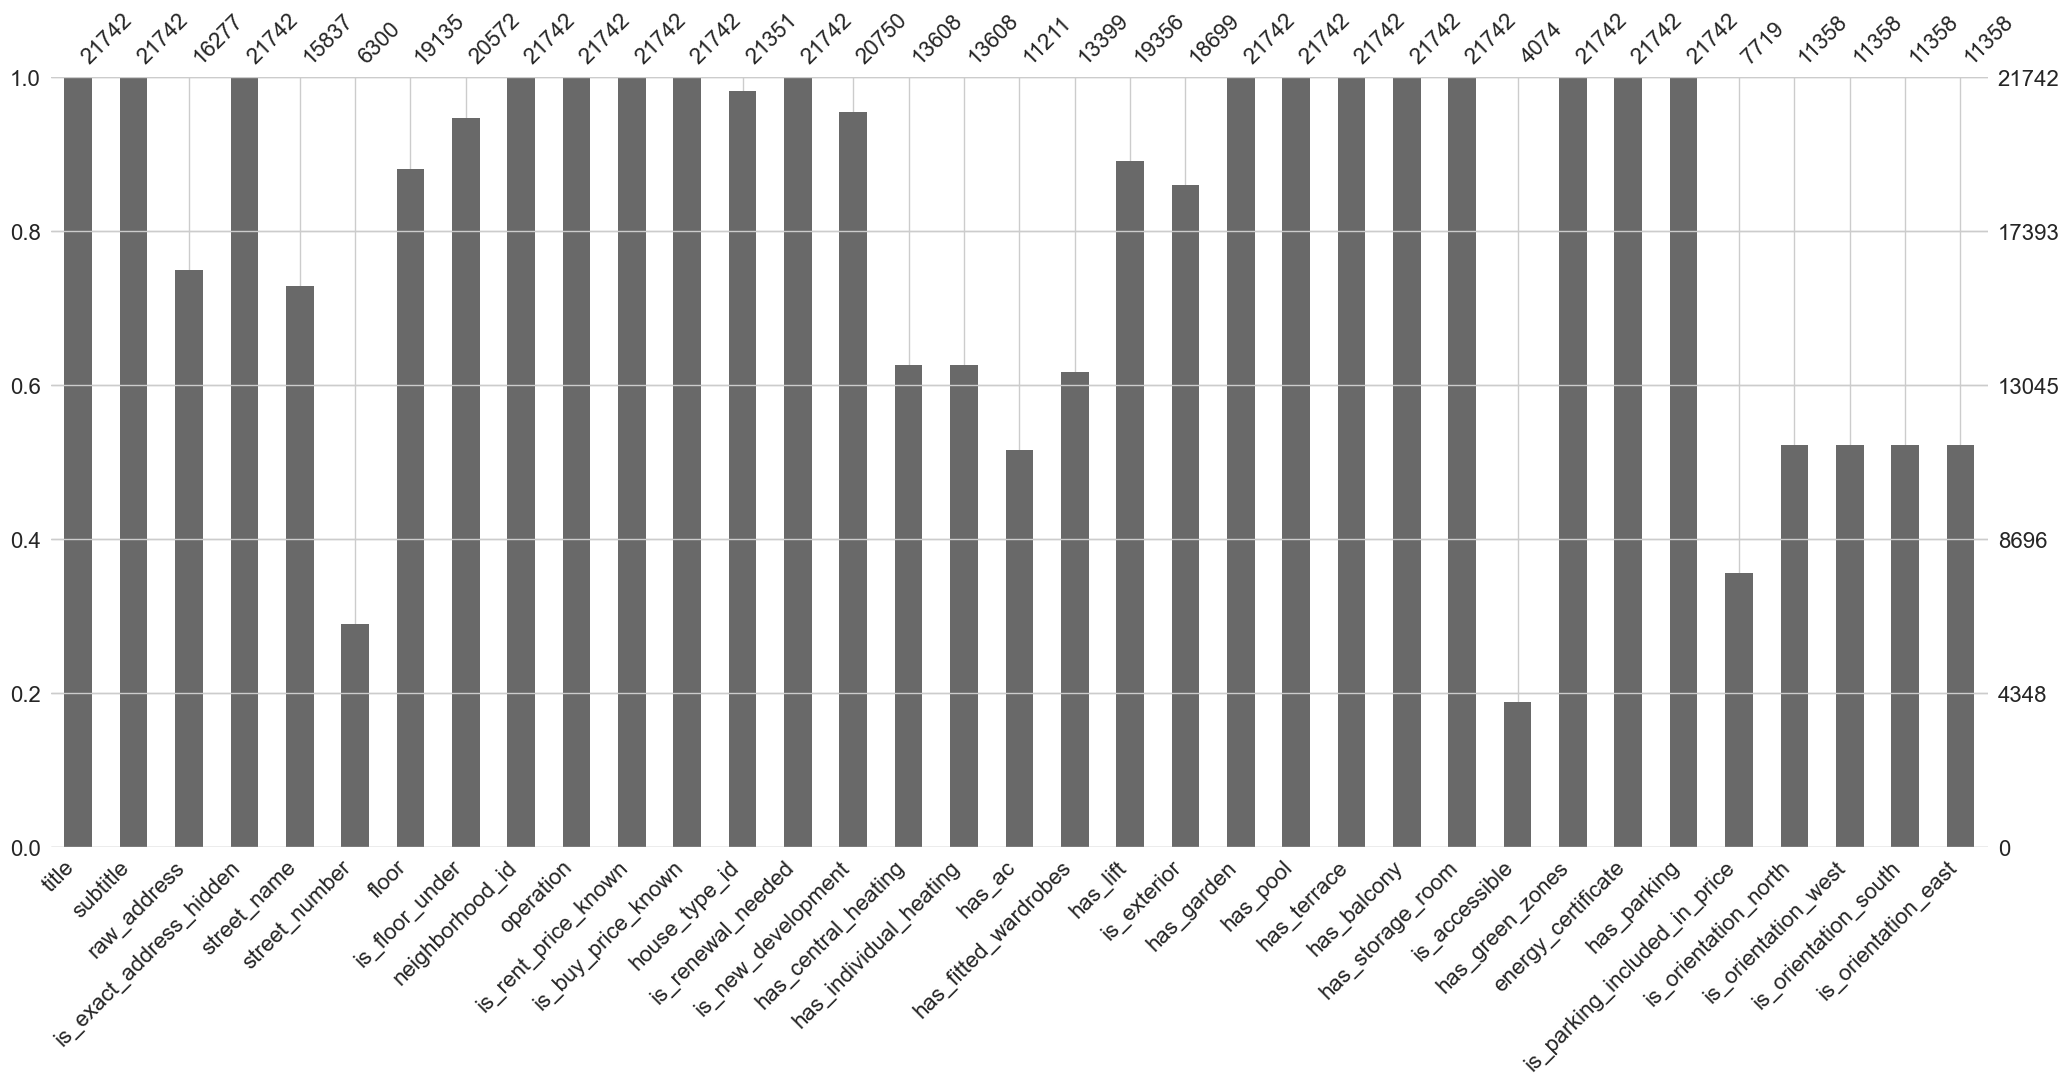

In [16]:
msno.bar(df.select_dtypes(include=['bool','object']))

Certaines colonnes ne seront pas utiles pour la suite. On les supprime du jeu de données.

In [17]:
col_obj_to_drop = ['title', 'subtitle', 'raw_address', 'street_name','is_rent_price_known','floor', 
                   'is_buy_price_known', 'street_number','operation','energy_certificate', 
                   'is_accessible','is_floor_under','is_new_development','has_central_heating',
                   'has_individual_heating','has_ac','has_fitted_wardrobes','is_exterior',
                   'is_parking_included_in_price','is_orientation_north','is_orientation_west',
                   'is_orientation_east','is_orientation_south','is_exact_address_hidden']
df.drop(col_obj_to_drop,axis=1,inplace=True)

La colonne Neighborhood contient un dictionnaire de plusieurs valeurs.  
On extrait ces valeurs sous forme de colonnes.

In [18]:
pattern = r'Neighborhood (\d+): ([\w\s]+) \(([\d\.]+) €/m2\) - District (\d+): ([\w\s]+)'
df[['Neighborhood_number', 'nom_quartier', 'euro_m2', 'district_number', 'district']] = df['neighborhood_id'].str.extract(pattern)
df['district_number'] = df['district_number'].fillna(16)

In [19]:
df.drop(['neighborhood_id','Neighborhood_number','euro_m2'],axis=1,inplace=True)

In [20]:
df[['district_number','district']].value_counts(dropna=False)

district_number  district          
16               NaN                   4035
11               Moncloa               1651
3                Carabanchel           1508
6                Chamberí              1463
5                Chamartín             1457
7                Ciudad Lineal         1315
13               Puente de Vallecas    1116
15               Salamanca             1110
8                Fuencarral            1068
17               Tetuán                1013
1                Arganzuela            1003
14               Retiro                 855
9                Hortaleza              823
21               Villaverde             814
10               Latina                 749
18               Usera                  643
4                Centro                 399
20               Villa de Vallecas      260
12               Moratalaz              257
19               Vicálvaro              178
2                Barajas                 25
Name: count, dtype: int64

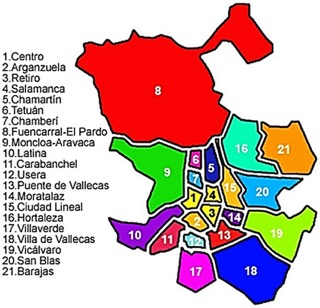

Il semble y a voir une erreur entre le nom et le numéro du district.

In [21]:
dico_district = {'1':'Centro',
                 '2': 'Arganzuela',
                 '3': 'Retiro',
                 '4': 'Salamanca',
                 '5': 'Chamartín',
                 '6': 'Tetuan',
                 '7': 'Chamberi',
                 '8': 'Fuencarral', 
                 '9': 'Moncloa',
                 '10': 'Latina',
                 '11': 'Carabanchel',
                 '12': 'Usera',
                 '13': 'Puente de Vallecas',
                 '14': 'Moratalaz',
                 '15': 'Ciudad Lineal',
                 '16': 'Hortaleza',
                 '17': 'Villaverde',
                 '18': 'Villa de Vallecas', 
                 '19': 'Vicalvaro',
                 '20': 'San Blas',
                 '21':'Barajas'}
df['nom_quartier'] = df['district_number'].map(dico_district)
df['district_number'] = df['district_number'].astype('int64')

In [22]:
df.loc[df['nom_quartier'].isna(),'nom_quartier']='Hortaleza'
df.drop('district',axis=1,inplace=True)

On utilise le dictionnaire afin de corriger le nom des quartiers.

In [23]:
df.dropna(subset=['house_type_id'], how='all', inplace=True)
df.loc[df['house_type_id'].str.contains("ticos"),'house_type_id'] = 'penthouse'
df.loc[df['house_type_id'].str.contains("plex"),'house_type_id'] = 'duplex'
df.loc[df['house_type_id'].str.contains("Casa"),'house_type_id'] = 'maison'
df.loc[df['house_type_id'].str.contains("Pisos"),'house_type_id'] = 'appartement'

On sépare les types de maisons par colonne.

In [24]:
df.loc[df['has_lift'].isna(),:]

,id,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,rent_price,buy_price,buy_price_by_area,house_type_id,is_renewal_needed,built_year,has_lift,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,has_green_zones,has_parking,parking_price,nom_quartier,district_number
15,21727,115.00,NaN,3,1.00,NaN,NaN,780,160000,1391,appartement,False,NaN,NaN,False,False,True,False,True,False,False,NaN,Barajas,21
23,21719,51.00,NaN,2,1.00,NaN,NaN,508,93000,1824,appartement,False,NaN,NaN,False,False,False,False,False,False,False,NaN,Barajas,21
25,21717,62.00,NaN,2,1.00,NaN,NaN,557,104000,1677,appartement,False,NaN,NaN,False,False,True,False,False,False,False,NaN,Barajas,21
32,21710,61.00,NaN,3,1.00,NaN,NaN,539,99900,1638,appartement,False,NaN,NaN,False,False,True,False,False,False,False,NaN,Barajas,21
85,21657,150.00,NaN,2,1.00,2.00,NaN,777,159000,1060,maison,True,1993.00,NaN,False,False,True,False,True,False,True,0.00,Barajas,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21729,13,59.00,NaN,3,1.00,NaN,NaN,788,162000,2746,appartement,False,1969.00,NaN,False,False,True,False,False,False,False,NaN,Arganzuela,2
21730,12,289.00,NaN,5,3.00,3.00,NaN,2369,820000,2837,maison,False,NaN,NaN,True,False,True,False,False,False,True,0.00,Arganzuela,2
21731,11,276.00,NaN,4,4.00,4.00,189.00,2103,690000,2500,maison,False,2005.00,NaN,True,True,True,False,False,False,True,0.00,Arganzuela,2
21733,9,267.00,215.00,5,3.00,2.00,382.00,2315,790000,2959,maison,False,2020.00,NaN,True,True,True,False,True,False,True,0.00,Hortaleza,16


In [25]:
df.groupby('house_type_id')['has_lift'].value_counts(dropna=False)

house_type_id  has_lift
appartement    True        13121
               False        4160
               NaN           424
duplex         True          555
               False         112
               NaN             9
maison         NaN          1938
penthouse      True          959
               False          67
               NaN             6
Name: count, dtype: int64

La colonne 'has_lift' contient des incohérences. Les penthouses sont par définition situés au dernier étage d'un building. Il est peu probable qu'il n'y ai pas d'ascenseur.  


In [26]:
df.loc[df['has_lift'].isna()]['house_type_id'].value_counts()

house_type_id
maison         1938
appartement     424
duplex            9
penthouse         6
Name: count, dtype: int64

Imputer les valeurs manquantes de 'has_lift' va être complexe et ne garantie pas de bons résultats.  
On supprime cette colonne.

In [27]:
df= df.drop('has_lift',axis=1)

<Axes: >

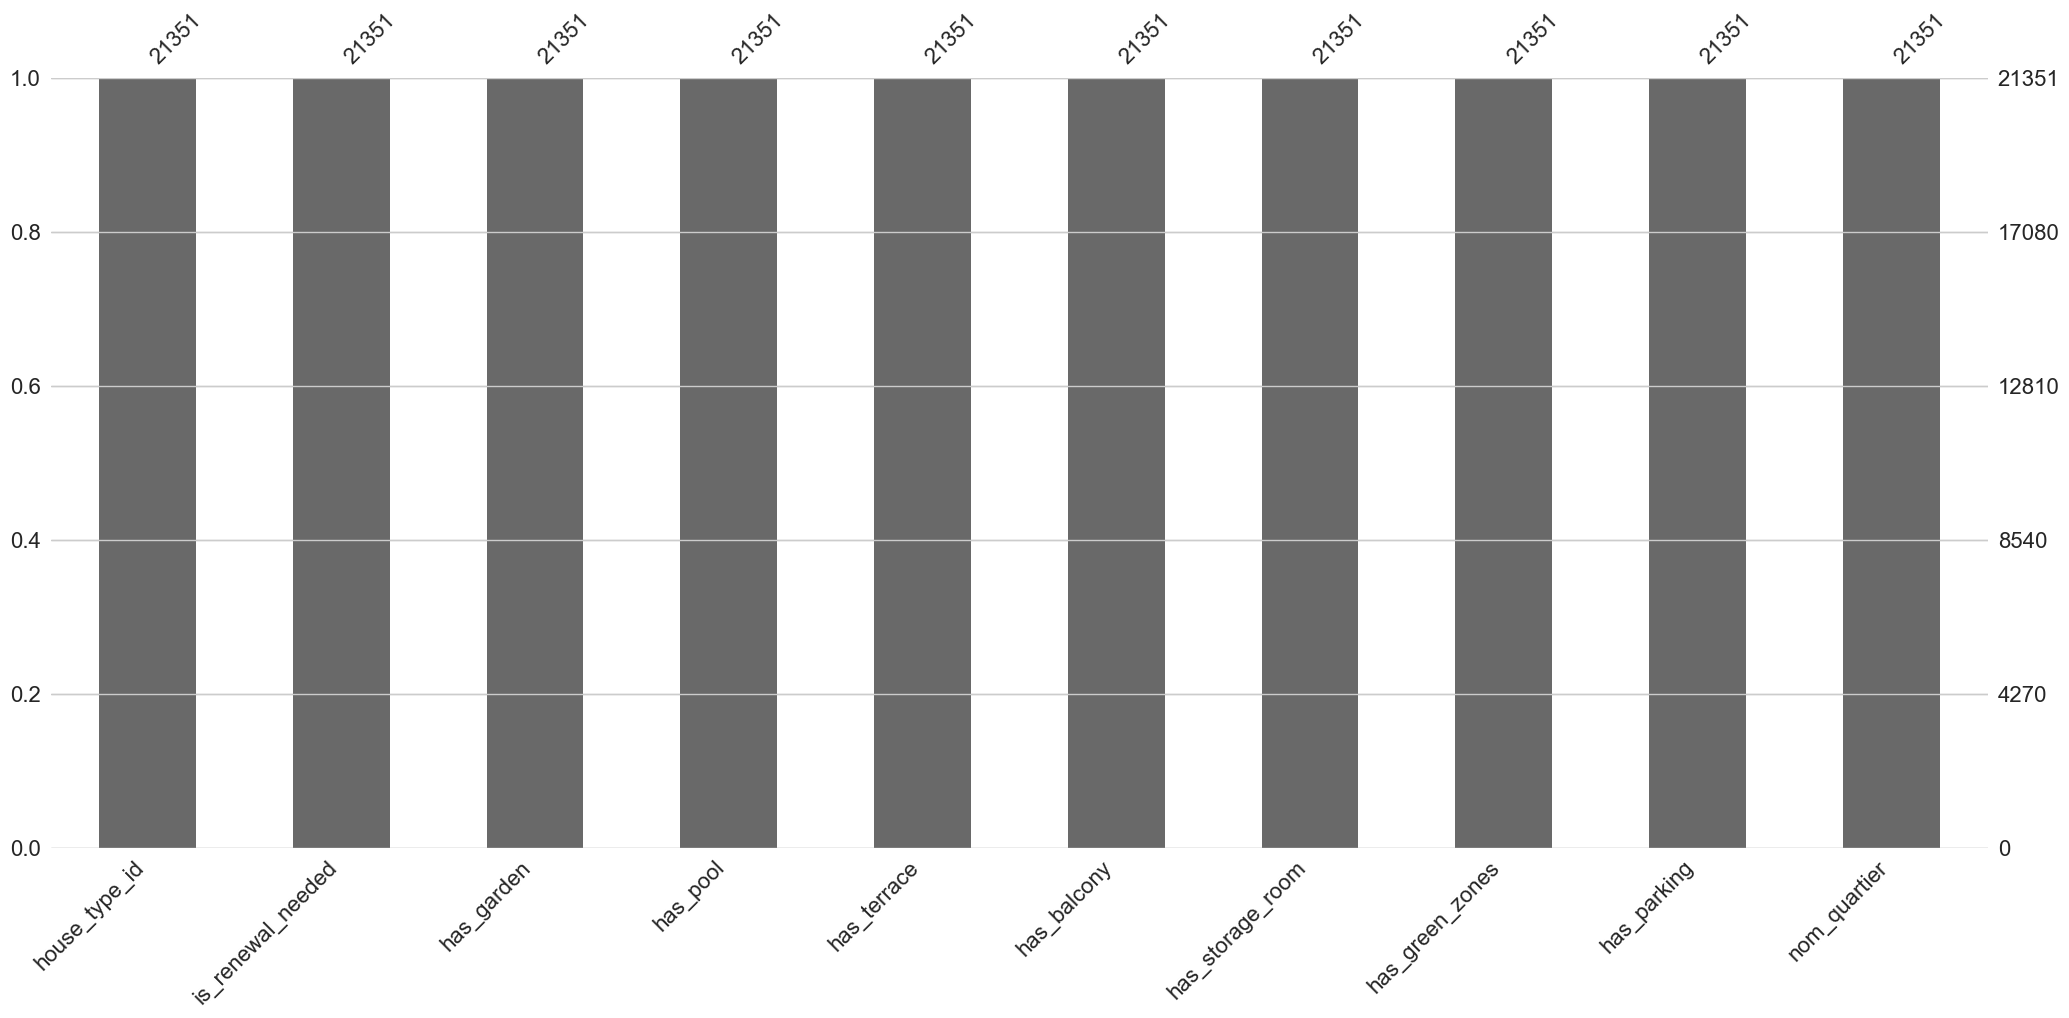

In [28]:
msno.bar(df.select_dtypes(include=['object','bool']))

Les variables catgorielles sont traitées. 

## Imputation des valeurs manquantes des variables quantitatives

<Axes: >

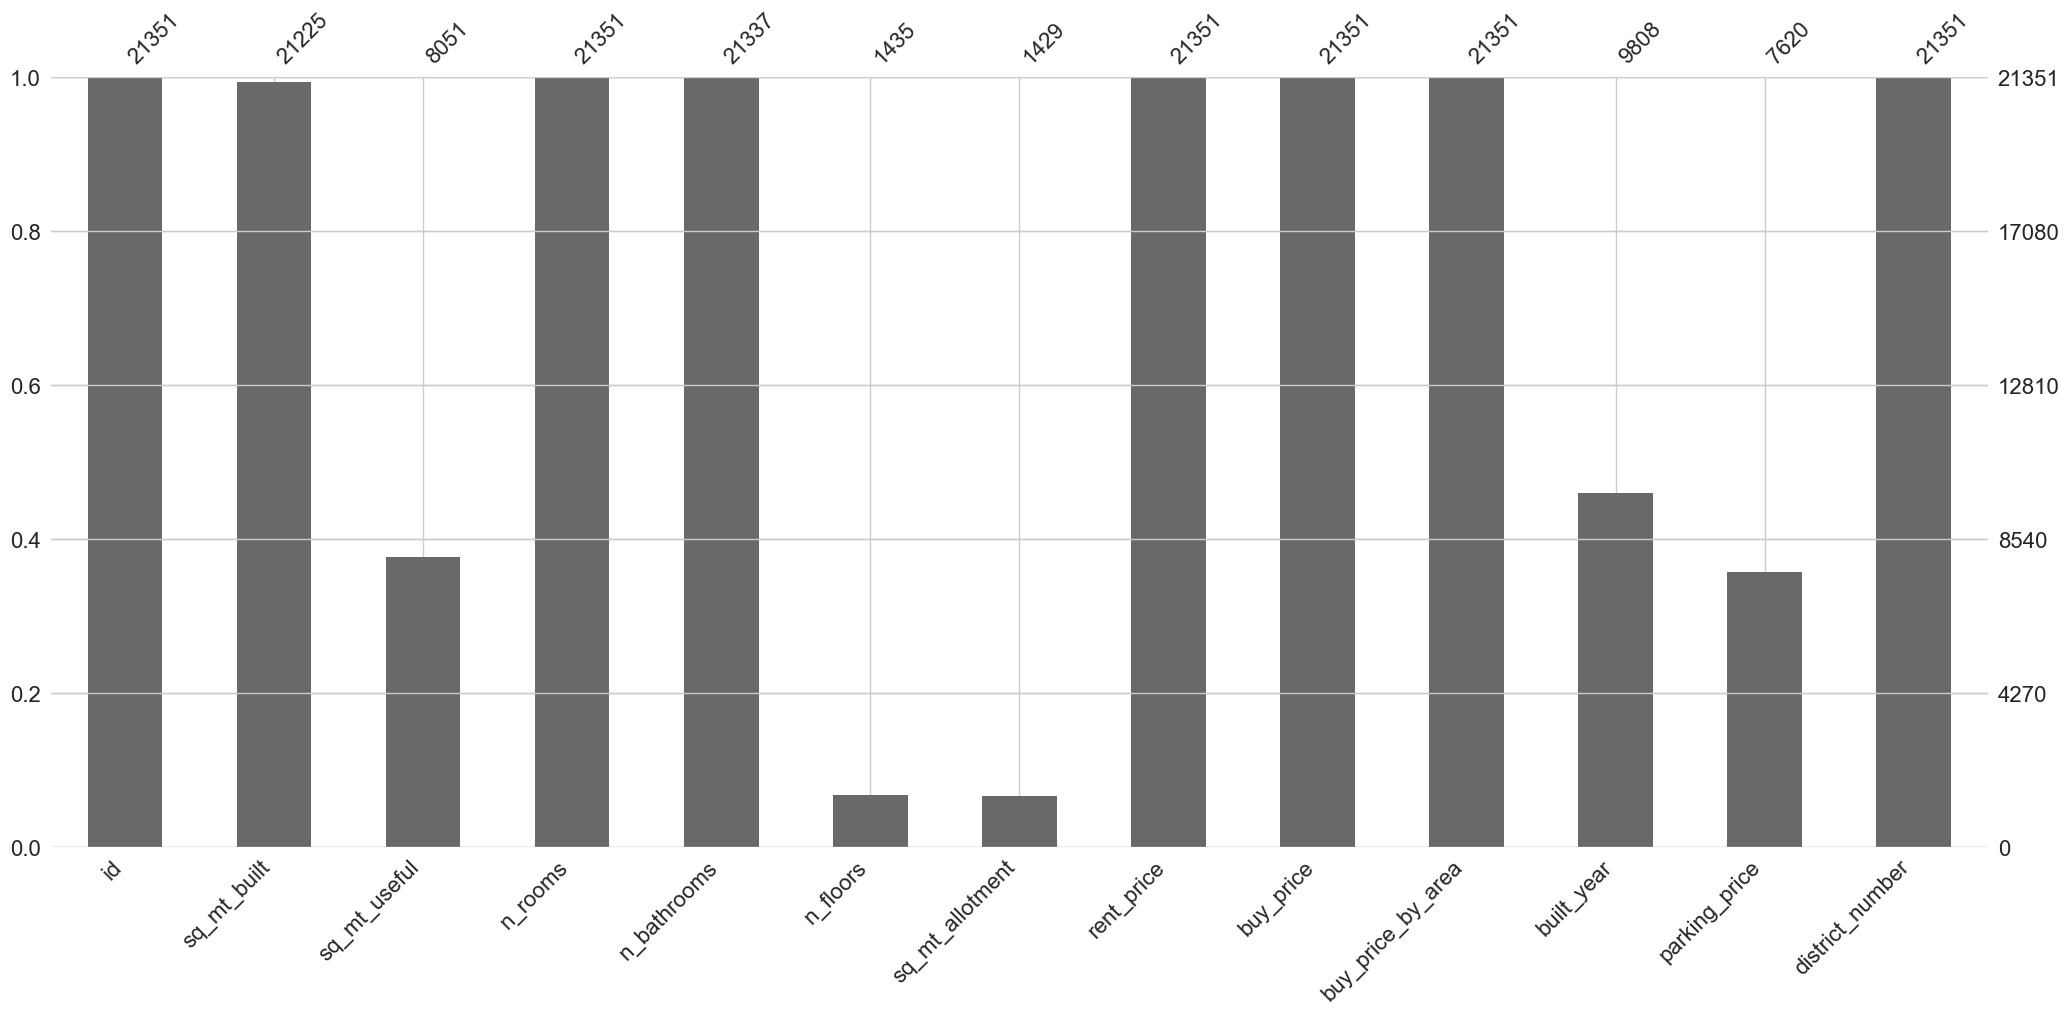

In [29]:
msno.bar(df.select_dtypes(include=['int','float']))

On supprime les colonnes qui ne seront pas utiles ou succeptibles de créer une multicolinéarité pour le modèle de régresssion.

In [30]:
df.drop(['sq_mt_allotment','sq_mt_useful','parking_price','rent_price'], axis=1, inplace=True)
df.dropna(subset=['sq_mt_built'], how='all', inplace=True)
df.dropna(subset=['n_bathrooms'], how='all', inplace=True) 
df.fillna({'n_floors': 0}, inplace=True)

In [31]:
for col in df.select_dtypes(include='number'):
    print(col)
    print('nombre de valeurs manquantes :',df[col].isna().sum())
    print('Valeur minimale :',df[col].min())
    print('Valeur maximale :',df[col].max())
    print('Valeurs présentes :',df[col].unique()[:10])
    print('* *'*20)

id
nombre de valeurs manquantes : 0
Valeur minimale : 1
Valeur maximale : 21742
Valeurs présentes : [21742 21741 21740 21739 21738 21737 21736 21735 21734 21733]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
sq_mt_built
nombre de valeurs manquantes : 0
Valeur minimale : 16.0
Valeur maximale : 999.0
Valeurs présentes : [ 64.  70.  94. 108. 126. 120. 125.  84.  85.  69.]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
n_rooms
nombre de valeurs manquantes : 0
Valeur minimale : 0
Valeur maximale : 24
Valeurs présentes : [2 3 4 5 1 8 6 0 9 7]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
n_bathrooms
nombre de valeurs manquantes : 0
Valeur minimale : 1.0
Valeur maximale : 14.0
Valeurs présentes : [ 1.  2.  3.  4.  6.  5. 14.  7.  9.  8.]
* ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** *
n_floors
nombre de valeurs manquantes : 0
Valeur minimale : 0.0
Valeur maximale : 5.0
Valeurs présentes : [0. 2. 3. 4. 1. 5.]
* ** ** ** ** ** ** ** ** **

La colonne 'n_rooms' contient des valeurs à 0 et la colonne built_year comprend beaucoup de données manquantes. 

In [32]:
df.loc[df['n_rooms']==0,:]

,id,sq_mt_built,n_rooms,n_bathrooms,n_floors,buy_price,buy_price_by_area,house_type_id,is_renewal_needed,built_year,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,has_green_zones,has_parking,nom_quartier,district_number
1405,20337,56.00,0,1.00,0.00,128000,2286,duplex,False,2008.00,False,True,True,False,False,True,True,Hortaleza,16
1409,20333,52.00,0,1.00,0.00,158000,3038,penthouse,False,NaN,False,True,True,True,False,False,True,Hortaleza,16
1503,20239,55.00,0,1.00,0.00,127000,2309,duplex,False,2010.00,False,True,True,False,False,True,True,Hortaleza,16
1510,20232,60.00,0,1.00,0.00,115000,1917,duplex,False,NaN,False,True,True,False,False,True,True,Hortaleza,16
1829,19913,61.00,0,1.00,0.00,105000,1721,duplex,False,2008.00,False,True,True,False,False,True,False,Hortaleza,16
1831,19911,55.00,0,1.00,0.00,119000,2164,duplex,False,NaN,False,True,True,False,False,True,True,Hortaleza,16
2002,19740,160.00,0,1.00,0.00,130000,812,appartement,True,NaN,False,False,True,False,False,True,False,Villa de Vallecas,18
2510,19232,140.00,0,1.00,0.00,475000,3393,appartement,True,NaN,False,False,False,False,False,False,False,Villaverde,17
2687,19055,181.00,0,2.00,0.00,825000,4558,appartement,True,NaN,False,False,True,False,False,False,True,Villaverde,17
2783,18959,50.00,0,1.00,0.00,240000,4800,duplex,False,NaN,False,False,False,False,False,False,False,Villaverde,17


On retire ces lignes du jeu de données.  
On remarque aussi une incohérence entre le nombre de pièces et le nombre de salle de bain.

In [33]:
df = df.loc[df['n_rooms']!=0,:]

In [34]:
df.loc[df['n_rooms']<df['n_bathrooms'],:]

,id,sq_mt_built,n_rooms,n_bathrooms,n_floors,buy_price,buy_price_by_area,house_type_id,is_renewal_needed,built_year,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,has_green_zones,has_parking,nom_quartier,district_number
1387,20355,54.00,1,2.00,0.00,185000,3426,appartement,False,NaN,False,True,False,False,True,True,True,Hortaleza,16
1415,20327,56.00,1,2.00,0.00,175000,3125,appartement,False,2007.00,False,True,False,False,True,False,True,Hortaleza,16
1528,20214,48.00,1,2.00,0.00,100000,2083,duplex,True,2008.00,False,True,False,True,False,True,True,Hortaleza,16
1538,20204,54.00,1,2.00,0.00,207000,3833,appartement,False,NaN,False,True,False,False,True,True,True,Hortaleza,16
1602,20140,97.00,2,3.00,0.00,225000,2320,duplex,False,NaN,False,False,True,False,False,True,True,San Blas,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21643,99,317.00,4,5.00,0.00,1995000,6293,appartement,False,NaN,False,False,False,True,False,False,False,Hortaleza,16
21663,79,351.00,4,5.00,0.00,1950000,5556,maison,False,NaN,True,False,False,False,False,False,True,Chamartín,5
21673,69,469.00,5,6.00,0.00,3500000,7463,maison,False,NaN,True,False,False,False,True,False,True,Chamartín,5
21675,67,351.00,4,5.00,3.00,2499000,7120,maison,False,2018.00,True,True,True,True,True,False,True,Chamartín,5


Il est peu probable d'avoir un logement à 1 pièce qui contient 2 salles de bain. Plutôt que de supprimer les lignes, on supprime la colonne n_bathrooms.  
C'est également le cas pour la colonne n_floors qui contient les mêmes incohérences que la colonne n_bathrooms.  
On la supprime également.

In [35]:
df = df.drop(['n_bathrooms','n_floors'],axis=1)

<Axes: >

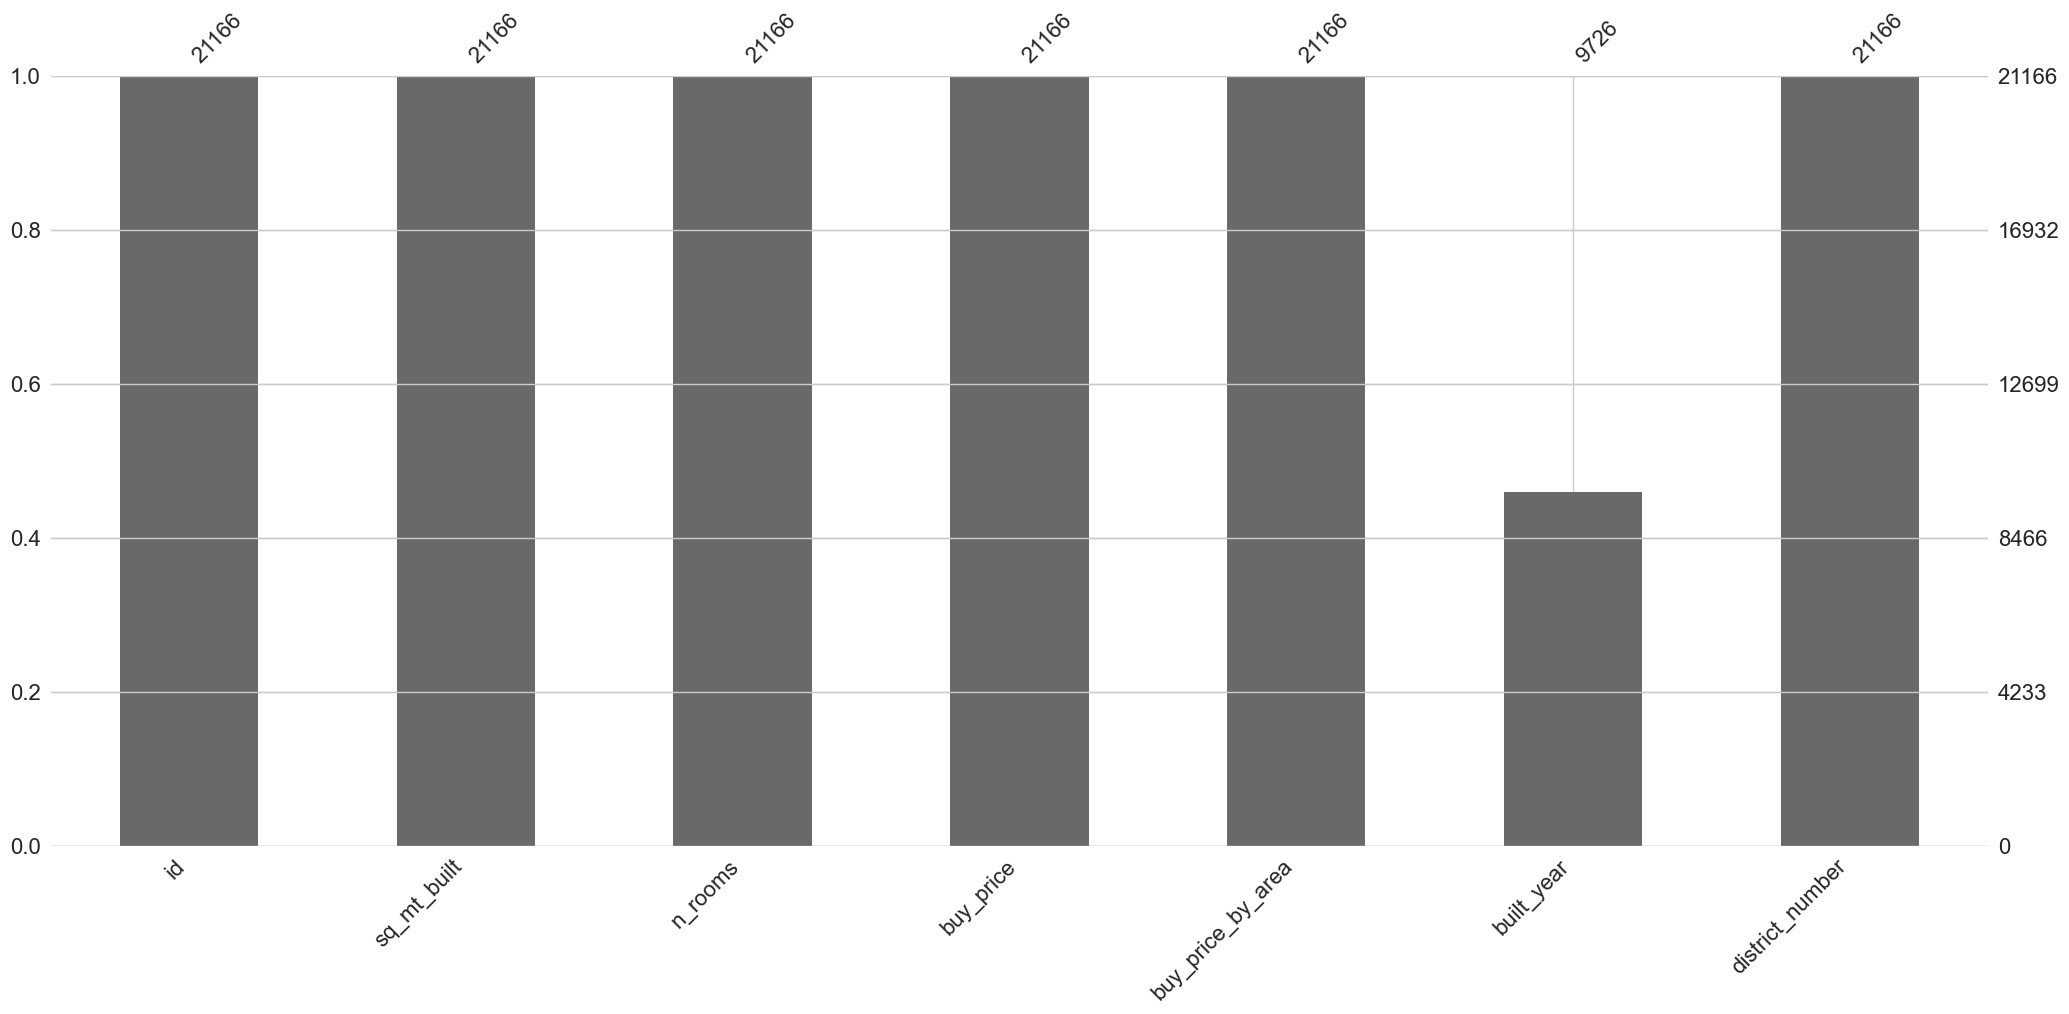

In [36]:
msno.bar(df.select_dtypes(include=['int','float']))

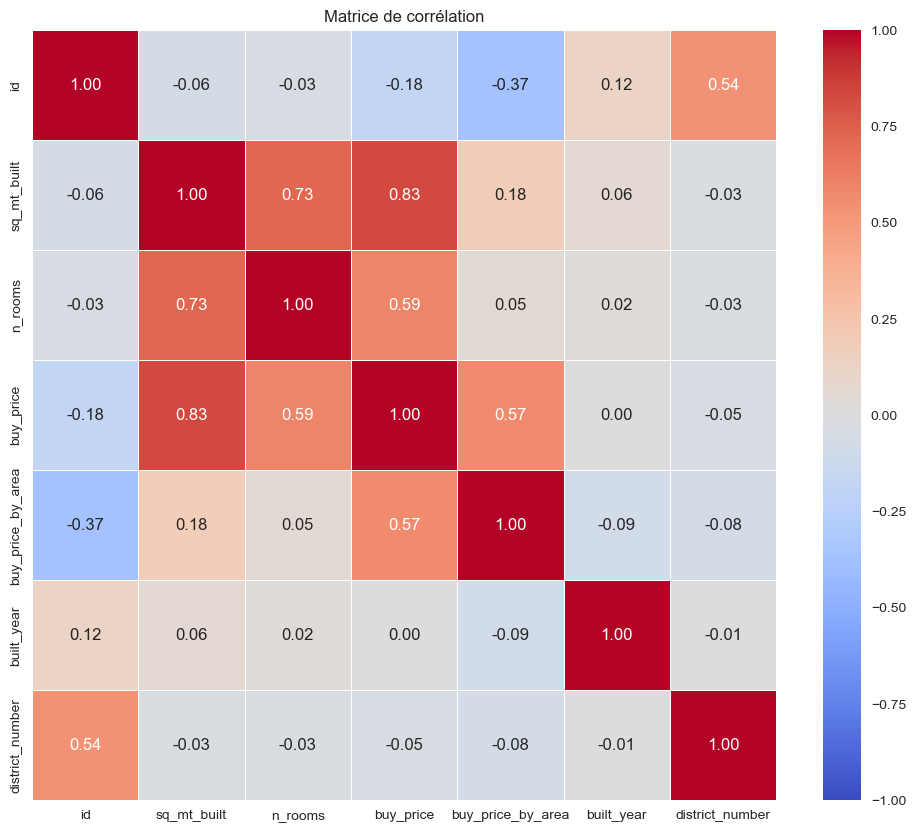

In [37]:
corr_matrix_0 = df.select_dtypes('number').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,vmin=-1,vmax=1)
plt.title('Matrice de corrélation')
plt.show()


Text(0.5, 1.0, 'Boxplots de la colonne "built_year" par type de logement')

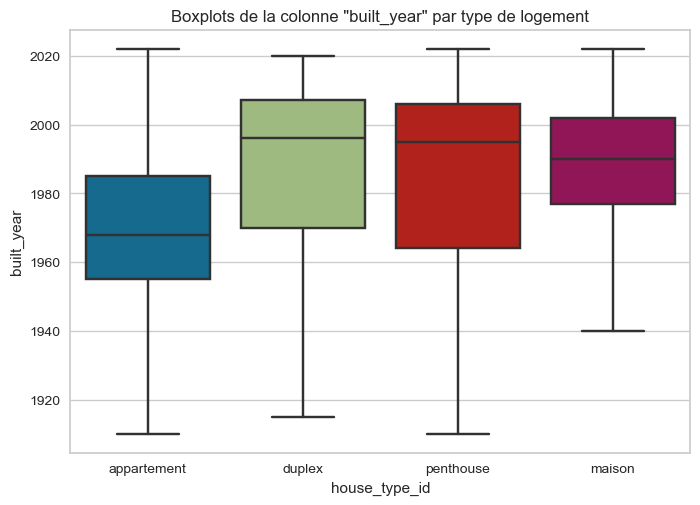

In [38]:
sns.boxplot(data=df,x='house_type_id',y='built_year',showfliers=False)
plt.title('Boxplots de la colonne "built_year" par type de logement')

Il semble y avoir corrélation entre le type de logement et l'année de construction mais ces éléments ne seront pas suffisant pour pouvoir imputer les valeurs manquantes de la colonne 'built_year'.  
On supprime la colonne 'built_year'.

In [39]:
df = df.drop('built_year',axis=1)

<Axes: >

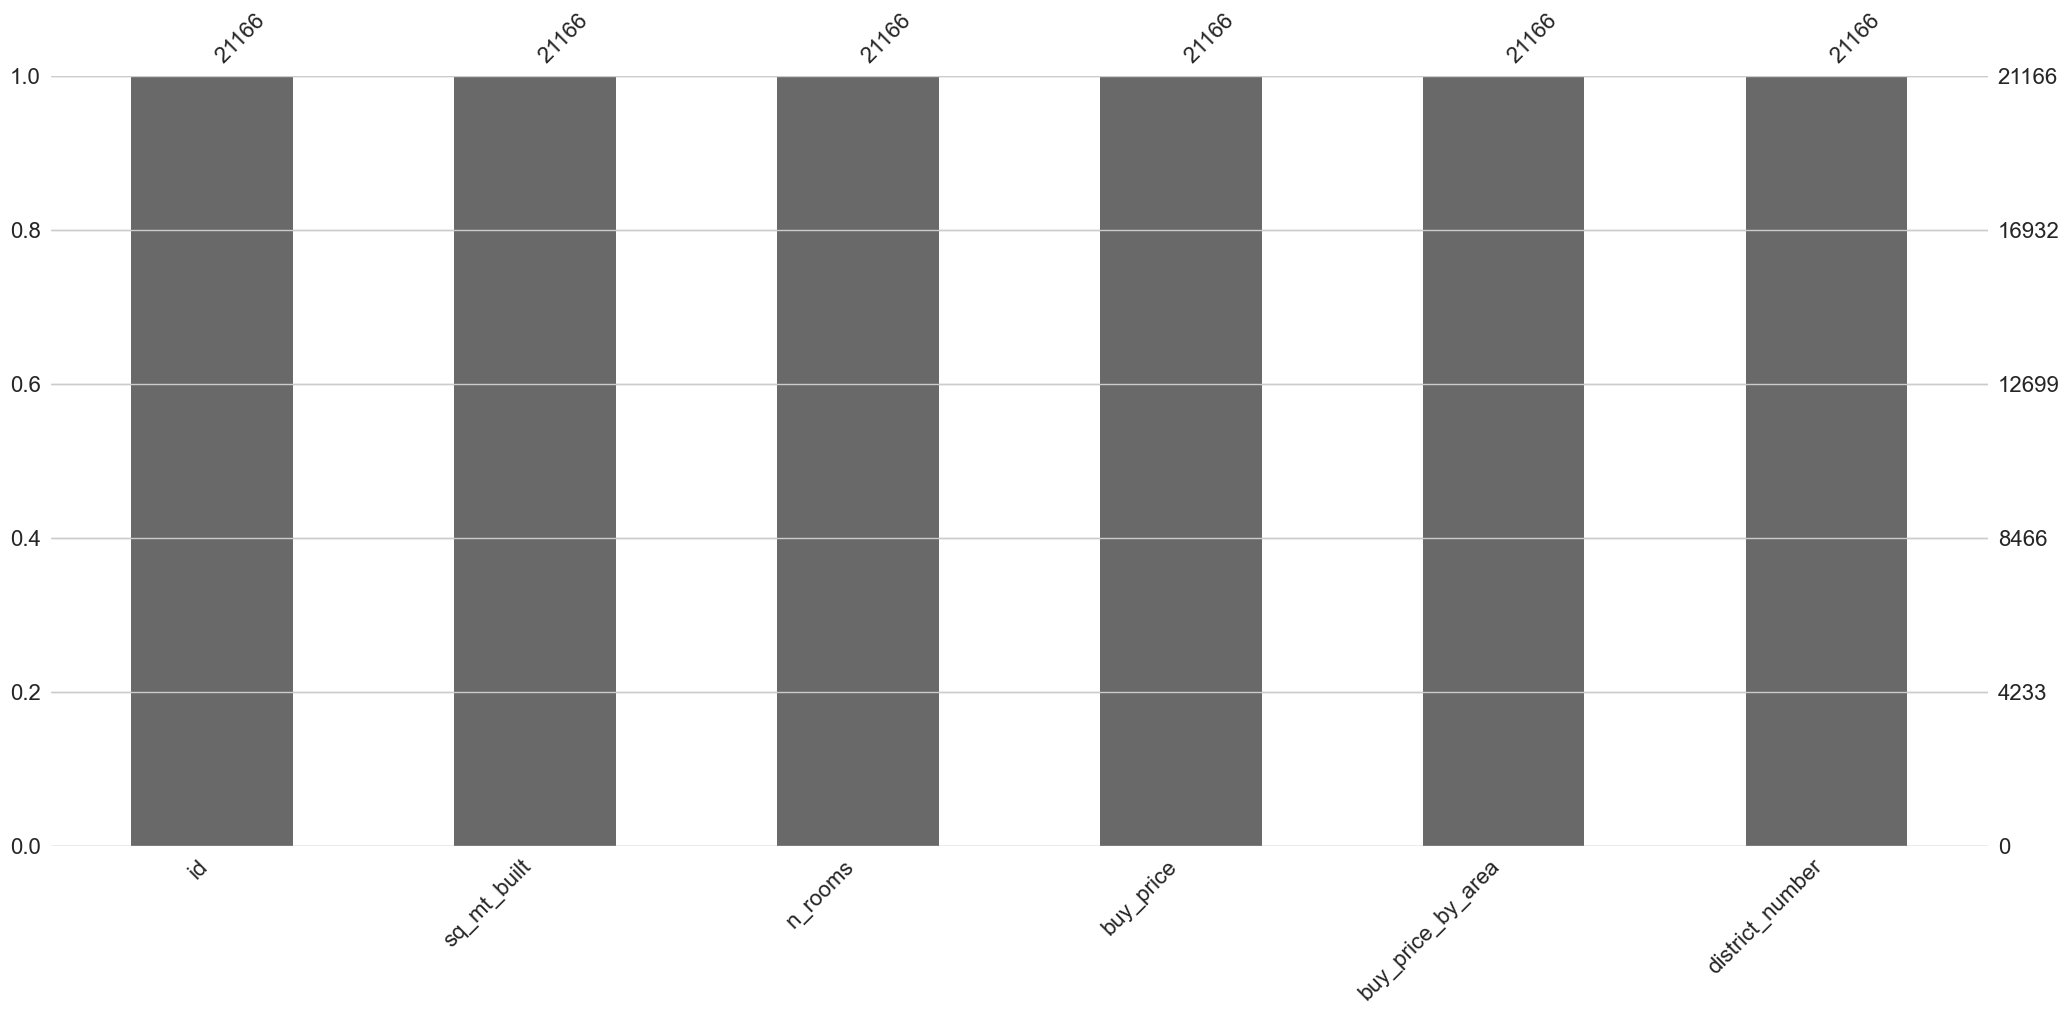

In [40]:
msno.bar(df.select_dtypes(include=['int','float']))

## Outliers

In [41]:
df.describe()

,id,sq_mt_built,n_rooms,buy_price,buy_price_by_area,district_number
count,21166.00,21166.00,21166.00,21166.00,21166.00,21166.00
mean,10856.47,148.65,3.04,644470.05,4022.31,11.00
std,6292.47,134.65,1.42,747482.71,1910.77,5.50
min,1.00,16.00,1.00,36000.00,536.00,1.00
25%,5413.25,71.00,2.00,199000.00,2551.00,6.00
50%,10822.50,101.00,3.00,379000.00,3723.00,11.00
75%,16323.75,165.00,4.00,765000.00,5000.00,16.00
max,21742.00,999.00,24.00,8800000.00,18889.00,21.00


In [42]:
df = df.loc[df['n_rooms']<12,:]

## Mise en forme du dataframe final

In [43]:
col_dict={'sq_mt_built':'m2_construit','n_rooms':'nb_pieces','buy_price':'prix_achat','buy_price_by_area':'prix_achat_m2','house_type_id':'type_maison',
         'is_renewal_needed':'travaux_necessaire','has_garden':'jardin',
         'has_pool':'piscine','has_terrace':'terrace','has_balcony':'balcon','has_storage_room':'salle_rangement',
         'has_green_zones':'espace_vert','has_parking':'parking','district_number':'num_quartier'}
df.rename(columns=col_dict, inplace=True)

In [44]:
df=df.astype({"m2_construit":int, "nb_pieces":int,'jardin':bool, 'piscine':bool, 'terrace':bool, 'balcon':bool, 'salle_rangement':bool, 'espace_vert':bool,
          'num_quartier':int})

In [45]:
df = pd.get_dummies(df, prefix=['type'], columns=['type_maison'])
df.drop('id', axis=1, inplace=True)

In [46]:
df['prix_achat'] = round(df['prix_achat'],2)

In [47]:
df = df[['m2_construit', 'nb_pieces', 'prix_achat', 'prix_achat_m2', 'travaux_necessaire','jardin', 'piscine', 
       'terrace', 'balcon', 'salle_rangement','espace_vert', 'parking', 'num_quartier',
       'type_appartement', 'type_duplex', 'type_maison', 'type_penthouse', 'nom_quartier']]

In [48]:
df_annee = df.copy()

In [49]:
visu = df_annee.copy()

In [50]:
visu.to_csv('visuel.csv')

## Analyse exploratoire

# Analyse univariée

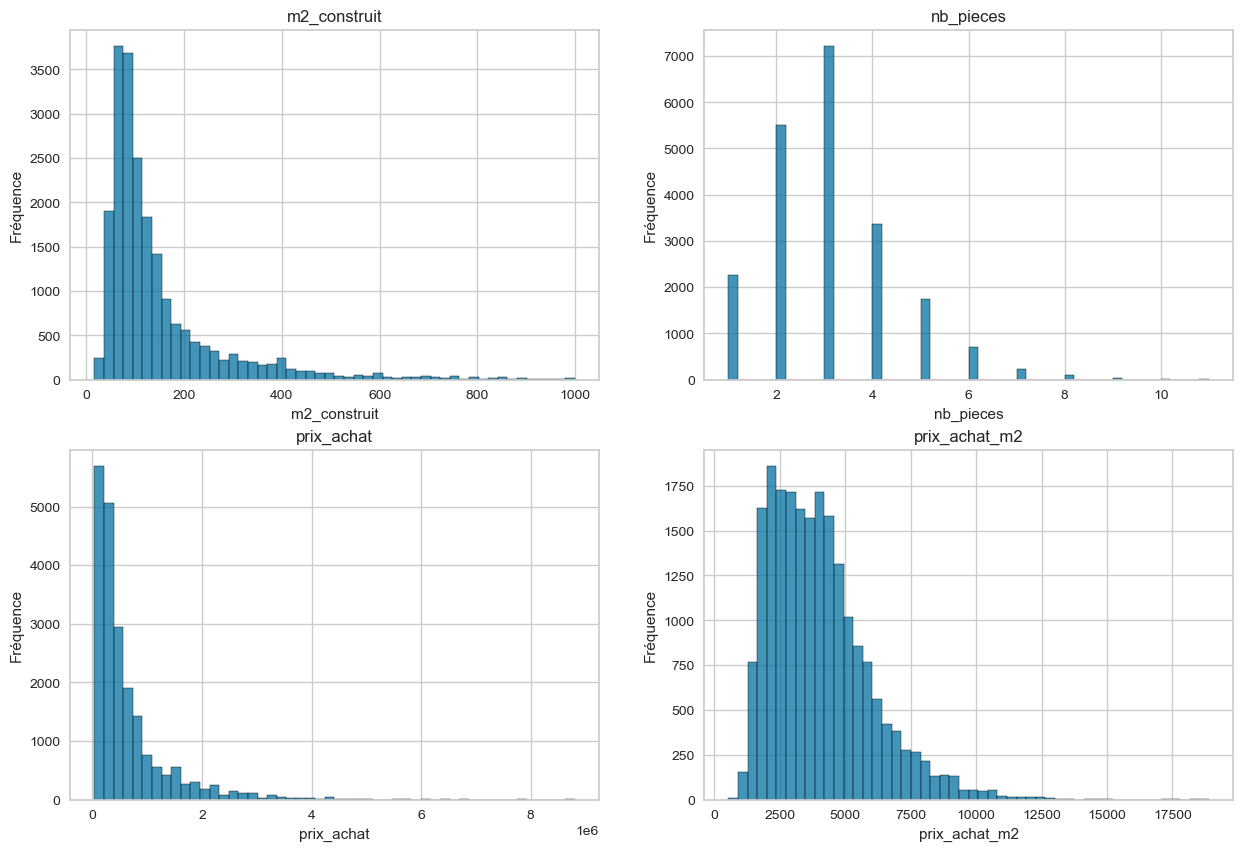

In [51]:
numeric_columns = ['m2_construit', 'nb_pieces', 'prix_achat', 'prix_achat_m2']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    sns.histplot(df_annee[column],bins=50, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{column}')
    axes[i//2, i%2].set_xlabel(column)
    axes[i//2, i%2].set_ylabel('Fréquence')
plt.show()

Ces graphiques nous permettent d'observer :  
* La superficie des logements du daframe est en moyenne de 148 mètres carrés et une médiane située à 101 mètres carrés.  
* Les logements contiennent en moyenne 3 pièces.  
* La moyenne des prix d'achat est de 643000 euros
* La moyenne du prix d'achat par mètre carré est de 4022 euros.
* La moyenne de superficie est de 148 mètres carrés et la médiane de 101 mètres carrés.

## Analyses bivariées

In [52]:
df_graphique = df_annee.copy()
df_graphique['type_logement'] = df_graphique.apply(lambda row: 
                               'appartement' if row['type_appartement'] else 
                               'duplex' if row['type_duplex'] else 
                               'maison' if row['type_maison'] else 
                               'penthouse' if row['type_penthouse'] else None, 
                               axis=1)

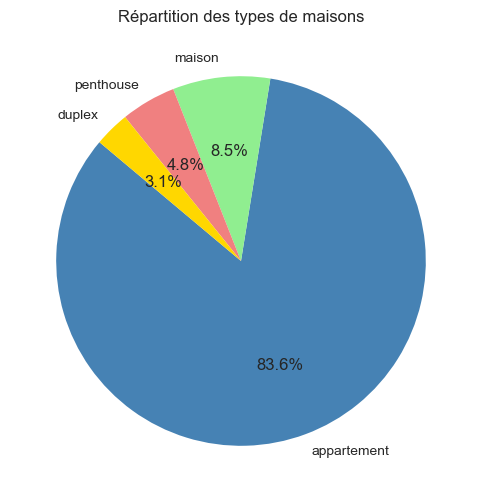

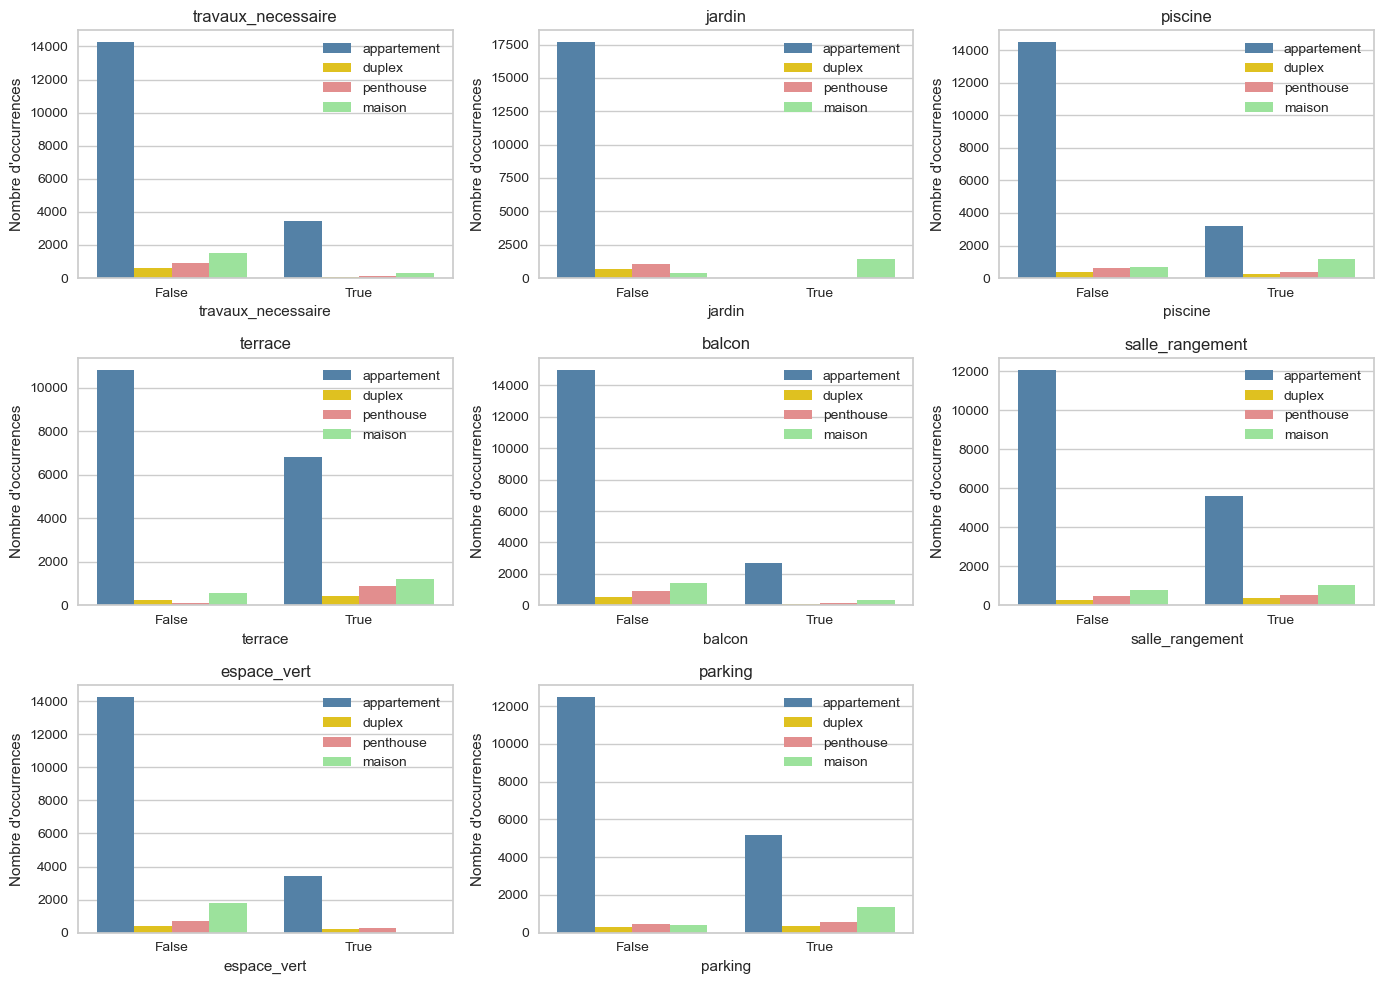

In [53]:
categorical_columns = ['travaux_necessaire', 'jardin', 'piscine', 'terrace', 'balcon', 'salle_rangement', 
                       'espace_vert', 'parking']

plt.figure(figsize=(8, 6))
df_graphique['type_logement'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['steelblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Répartition des types de maisons')
plt.ylabel('')
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))
for i, cat in enumerate(categorical_columns):
    ax = axes[i//3, i%3]
    sns.countplot(data=df_graphique, x=cat, hue='type_logement', ax=ax,palette=['steelblue', 'gold', 'lightcoral', 'lightgreen'])
    ax.set_title(f'{cat}')
    ax.set_xlabel(cat)
    ax.set_ylabel('Nombre d\'occurrences')
    ax.legend(loc='upper right')
plt.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()


**Observations :**  
* Le jeu de données contient principalement des appartements (83,6%)
* Seulement des maisons possèdent un jardin. 
* Plus de 6000 appartements possèdent une terrace et 3000 un balcon. 
* Certains appartements possèdent une piscine (dans l'immeuble ou bien une erreur de saisie??)


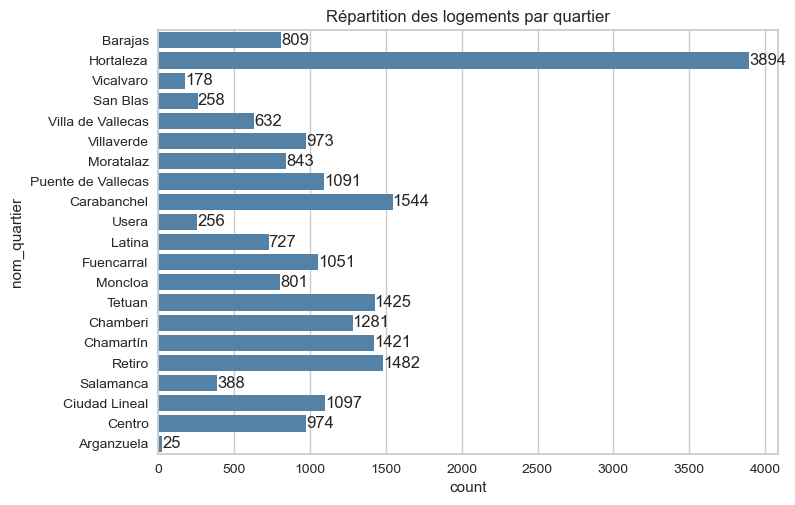

In [54]:
ax1=sns.countplot(data=df_graphique, y='nom_quartier',color='steelblue')
ax1.bar_label(ax1.containers[0])
plt.title('Répartition des logements par quartier')
plt.show()


La répartition des logements n'est pas équilibrée entre les quartiers.  
La majorité des logements du dataframe se trouvent à Hortaleza (3894) alors qu'à Arganzuela, il n'y en a que 25.

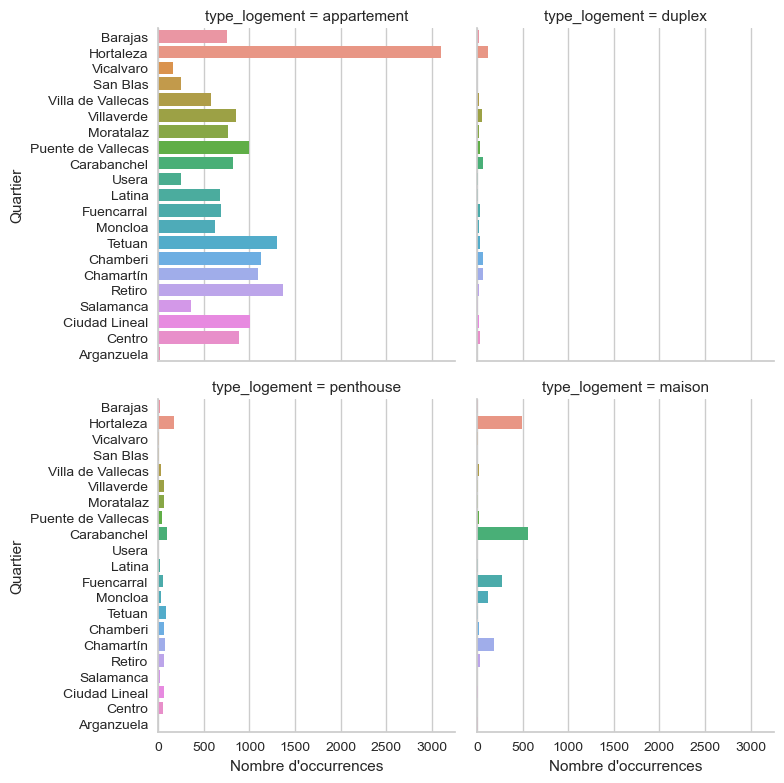

In [55]:
g = sns.catplot(data=df_graphique, y='nom_quartier', col='type_logement', kind='count',col_wrap=2, height=4)
g.set_axis_labels('Nombre d\'occurrences', 'Quartier')
plt.tight_layout()
plt.show()


**Observations:**  
* Il y a des appartements dans tous les quartiers
* Les duplex et penthouses sont majoritairement à Hortaleza
* Le quartier Carabanchel compte le plus de maisons.
* Certains quartiers n'ont pas de duplex, de penthouses ou de maisons.

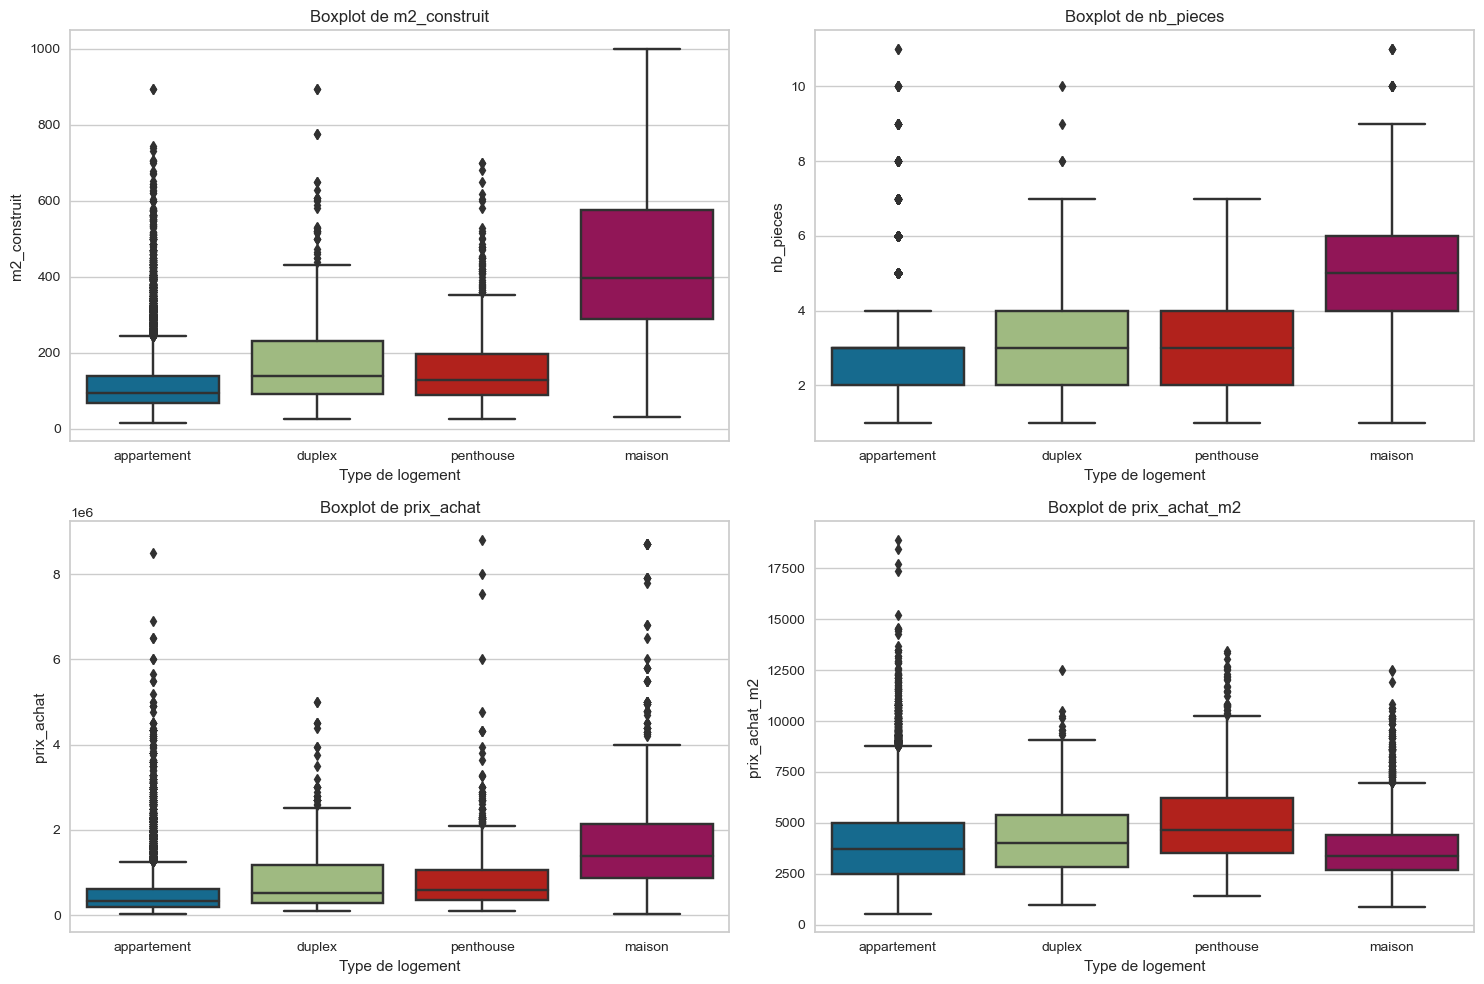

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    sns.boxplot(data=df_graphique, x='type_logement', y=column, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Boxplot de {column}')
    axes[i//2, i%2].set_xlabel('Type de logement')
    axes[i//2, i%2].set_ylabel(column)
plt.tight_layout()
plt.show()

**Observations :**  
* Les maisons ont une superficie plus grande que les autres catégories et donc plus de pièces.
* Les maisons ont aussi un prix d'achat plus élevé que les autres catégories mais c'est le penthouse qui a un prix d'achat au mètre carré le plus élevé. 

# Tests différents modèles de regression

## Regression linéaire simple

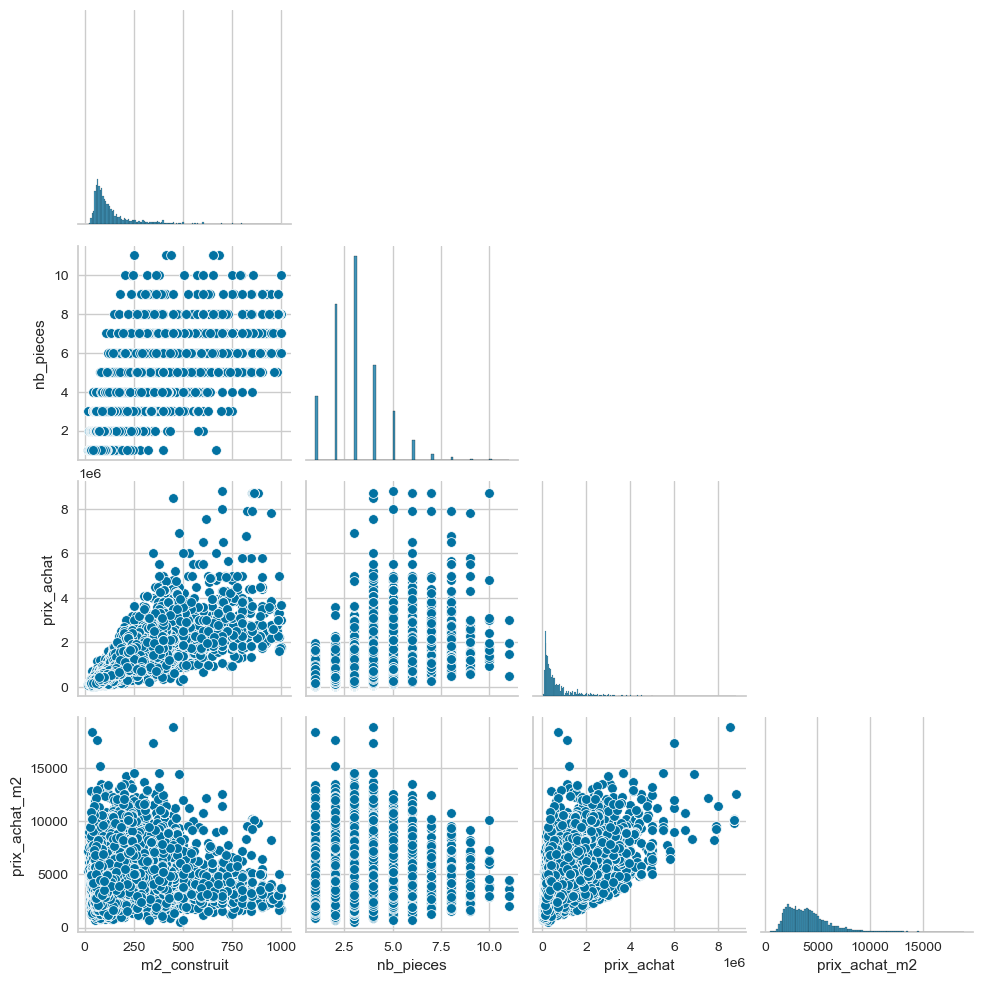

In [57]:
sns.pairplot(data=df_annee[['m2_construit', 'nb_pieces', 'prix_achat', 'prix_achat_m2',]],corner=True)

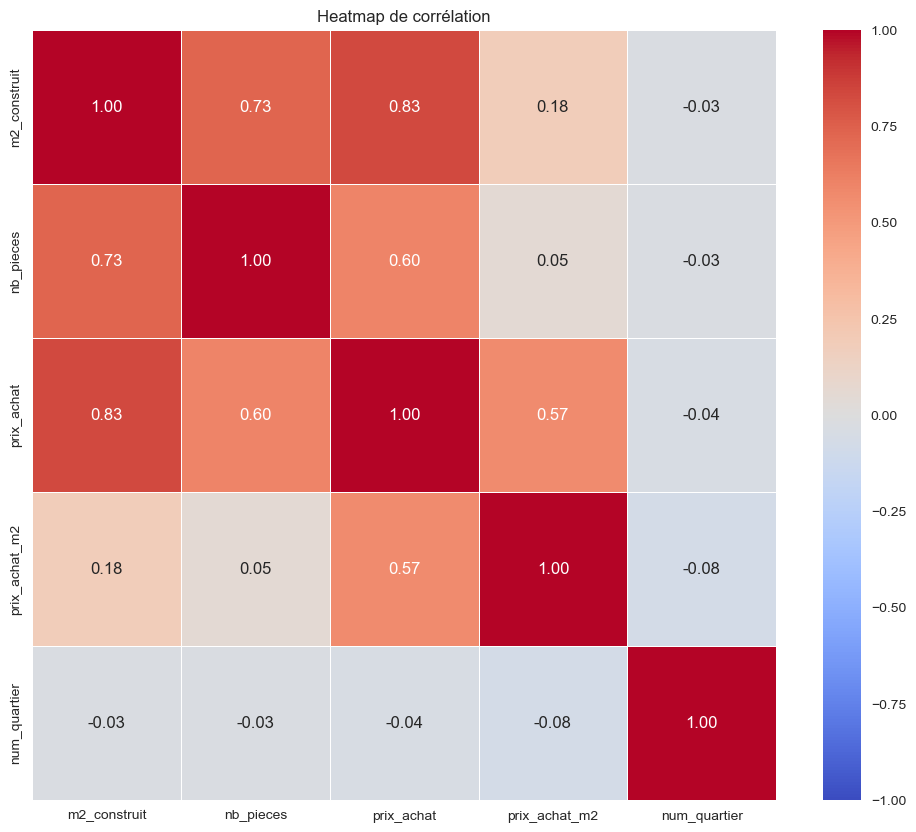

In [58]:
corr_matrix = df_annee.select_dtypes('number').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,vmin=-1,vmax=1)
plt.title('Heatmap de corrélation')
plt.show()


Je commence par un modèle de régression linéaire simple que j'utiliserai comme baseline pour comparer les scores avec les autres modèles.  
La matrice de corrélation indique que la variable m2_construit est la variable la plus corrélée à la target 'prix_achat'.

## Régression simple avec la feature 'm2_construit'

In [59]:
X = df_annee['m2_construit'].values.reshape(-1, 1)
y = df_annee['prix_achat']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)


scaler_reg = RobustScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)

X_test_reg_scaled = scaler_reg.transform(X_test_reg)

regression = LinearRegression()

regression.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = regression.predict(X_test_reg_scaled)

r2_train = regression.score(X_train_reg_scaled, y_train_reg)
r2_predict = regression.score(X_test_reg_scaled, y_test_reg)

print('R² train :', r2_train)
print('R² predict:', r2_predict)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("MAE:", mae)

mse = mean_squared_error(y_test_reg, y_pred_reg)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

R² train : 0.689600706899885
R² predict: 0.6943014502207373
MAE: 221236.6008243211
MSE: 160837423696.19153
RMSE: 401045.4135084848


La regréssion linéaire affiche un score de prédiction de 0.71.  


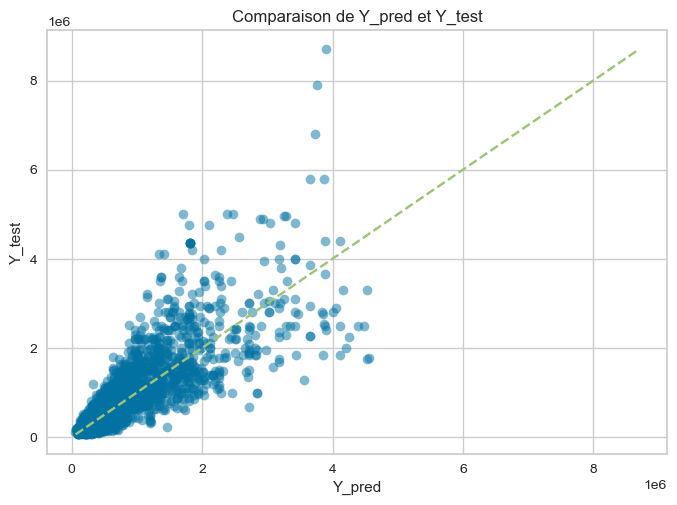

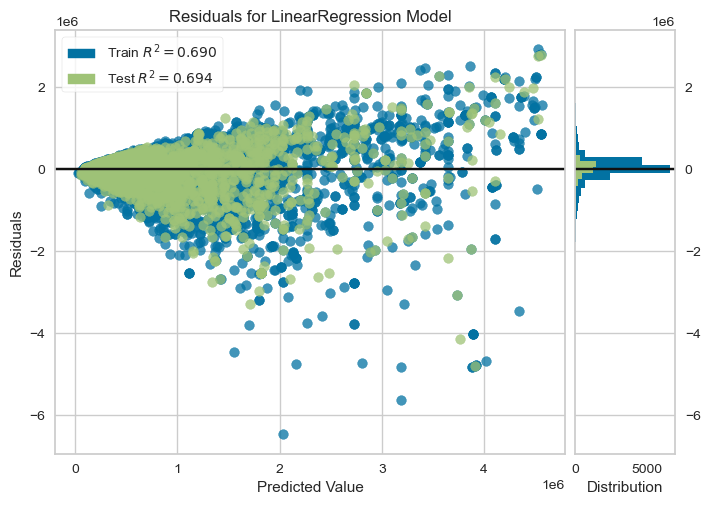

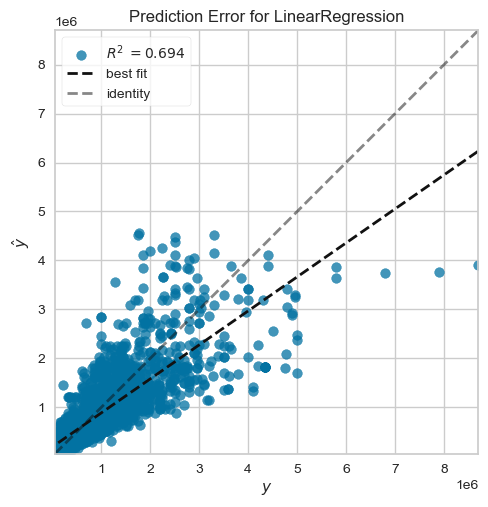

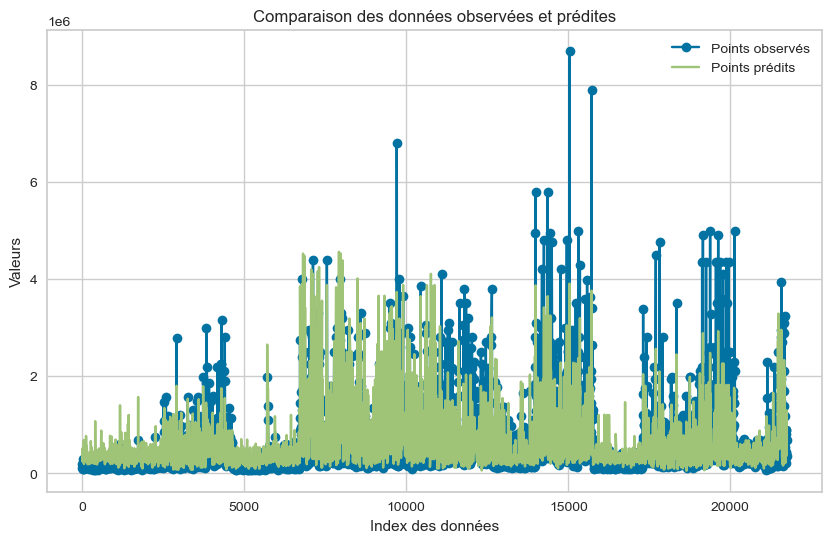

In [60]:
plt.plot(y_pred_reg, y_test_reg, 'o', alpha=0.5)
min_true = y_test_reg.min()
max_true = y_test_reg.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.show()

visualizer = ResidualsPlot(regression)
visualizer.fit(X_train_reg_scaled, y_train_reg)
visualizer.score(X_test_reg_scaled, y_test_reg)
visualizer.show()

visualizer = PredictionError(regression)
visualizer.fit(X_train_reg_scaled, y_train_reg)
visualizer.score(X_test_reg_scaled, y_test_reg)
visualizer.show()


donnees_comparatives_reg = pd.DataFrame({'points_observés': y_test_reg, 'points_predits': y_pred_reg})
donnees_comparatives_reg = donnees_comparatives_reg.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_reg.index, donnees_comparatives_reg['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_reg.index, donnees_comparatives_reg['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()

## Modèle ElasticNetCV 

In [61]:
data_en = df_annee.drop(['prix_achat','nom_quartier'], axis=1)
target_en = df_annee['prix_achat']

X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(data_en, target_en, test_size=0.2, random_state=42)

scaler_en = RobustScaler()

X_train_en_scaled = scaler_en.fit_transform(X_train_en)

X_test_en_scaled = scaler_en.transform(X_test_en)

model_en = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
                        max_iter=10000)

model_en.fit(X_train_en_scaled, y_train_en)

pred_train_en = model_en.predict(X_train_en_scaled)
pred_test_en = model_en.predict(X_test_en_scaled)

mae_test = mean_absolute_error(y_test_en, pred_test_en)
mse_test = mean_squared_error(y_test_en, pred_test_en)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train_en, pred_train_en)
r2_test = r2_score(y_test_en, pred_test_en)

print("R2 train:", r2_train)
print("R2 test:", r2_test)
print("MAE:", mae_test)
print("MSE:", mse_test)
print("RMSE:", rmse_test)


R2 train: 0.8783411703336319
R2 test: 0.8795722880524944
MAE: 147012.43637715434
MSE: 63360728878.98861
RMSE: 251715.57138760528


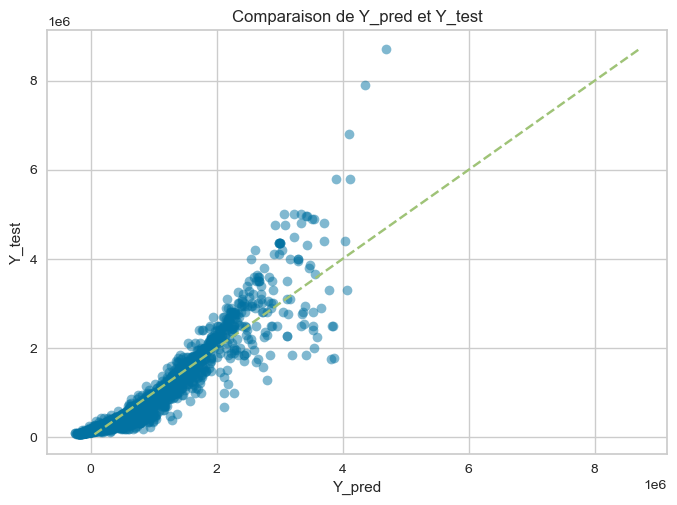

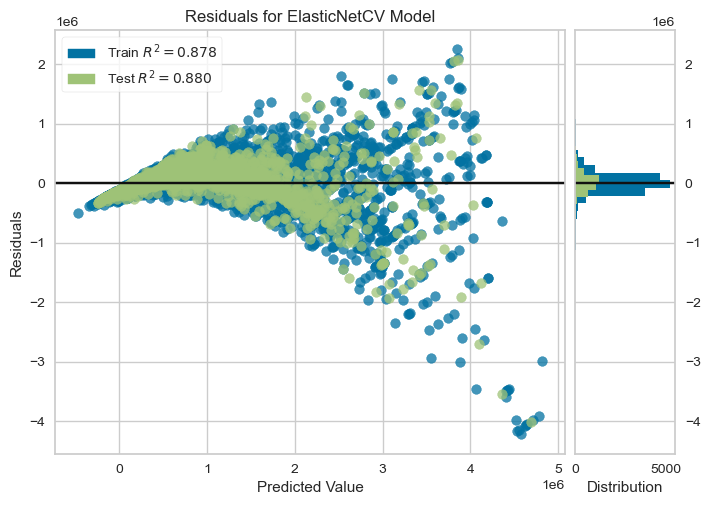

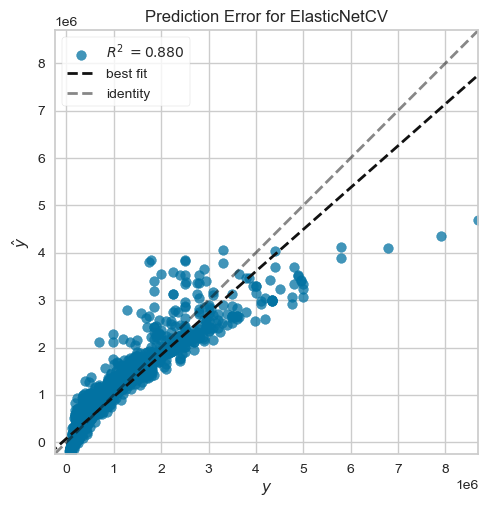

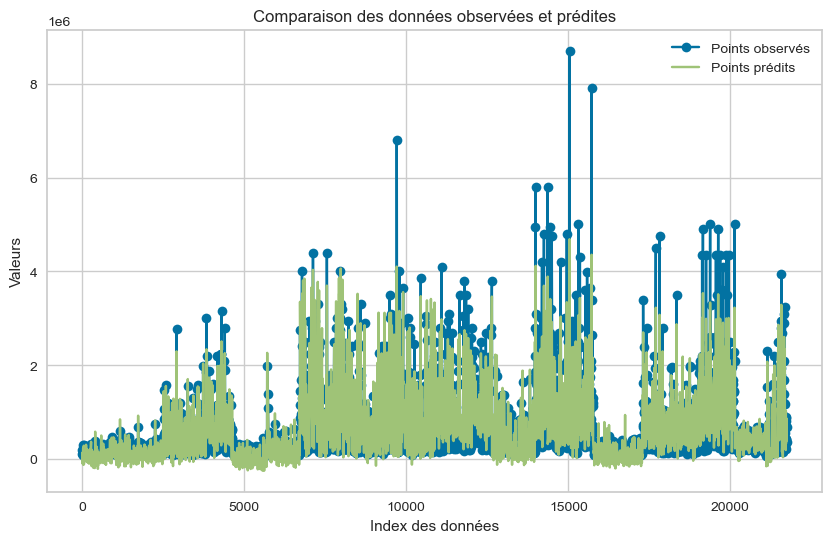

In [62]:
plt.plot(pred_test_en, y_test_en, 'o', alpha=0.5)
min_true = y_test_en.min()
max_true = y_test_en.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.show()

visualizer = ResidualsPlot(model_en)
visualizer.fit(X_train_en_scaled, y_train_en)  
visualizer.score(X_test_en_scaled, y_test_en)  
visualizer.show()

visualizer = PredictionError(model_en)
visualizer.fit(X_train_en_scaled, y_train_en)
visualizer.score(X_test_en_scaled, y_test_en)
visualizer.show()

donnees_comparatives_model_en = pd.DataFrame({'points_observés': y_test_en, 'points_predits': pred_test_en})
donnees_comparatives_model_en = donnees_comparatives_model_en.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_en.index, donnees_comparatives_model_en['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_en.index, donnees_comparatives_model_en['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()



Ce deuxième modèle obtient un meilleur score que la régression linéaire simple mais il affiche un RMSE à 251715 ce qui représente une marge d'erreur trop grande pour que le modèle soit efficace.  
Je vais reprendre le modèle mais en vérifiant au préalable si les variables explicatives sont en multicollinéarité avec le calcul du VIF. 

In [63]:
colonnes_bool = X_train_en.select_dtypes(include='bool')
for col in colonnes_bool:
    X_train_en[col] = X_train_en[col].astype(int)

In [64]:
numeric_columns = ['m2_construit',
 'nb_pieces',
 'prix_achat_m2',
 'travaux_necessaire',
 'jardin',
 'piscine',
 'terrace',
 'balcon',
 'salle_rangement',
 'espace_vert',
 'parking',
 'num_quartier',
 'type_appartement',
 'type_duplex',
 'type_maison',
 'type_penthouse']

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X_train_en[numeric_columns].values, i) for i in range(len(numeric_columns))]

print('VIF (facteur d\'inflation de la variance) pour les variables numériques :')
print(vif_data)

VIF (facteur d'inflation de la variance) pour les variables numériques :
               feature   VIF
0         m2_construit  3.48
1            nb_pieces  2.36
2        prix_achat_m2  1.17
3   travaux_necessaire  1.10
4               jardin  4.89
5              piscine  1.99
6              terrace  1.16
7               balcon  1.03
8      salle_rangement  1.41
9          espace_vert  1.64
10             parking  1.77
11        num_quartier  1.02
12    type_appartement 14.43
13         type_duplex  1.57
14         type_maison  6.98
15      type_penthouse  2.05


Une valeur supérieure à 10 indique multicolinéarité des variables.  


In [65]:
numeric_columns = ['m2_construit', 'prix_achat_m2', 'travaux_necessaire',
 'jardin', 'piscine','terrace','balcon','salle_rangement','espace_vert','parking','num_quartier',
 'type_duplex', 'type_maison', 'type_penthouse']

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X_train_en[numeric_columns].values, i) for i in range(len(numeric_columns))]

print('VIF (facteur d\'inflation de la variance) pour les variables numériques :')
print(vif_data)

VIF (facteur d'inflation de la variance) pour les variables numériques :
               feature  VIF
0         m2_construit 4.78
1        prix_achat_m2 3.91
2   travaux_necessaire 1.26
3               jardin 5.24
4              piscine 2.58
5              terrace 1.88
6               balcon 1.22
7      salle_rangement 2.19
8          espace_vert 1.98
9              parking 2.73
10        num_quartier 3.02
11         type_duplex 1.07
12         type_maison 5.52
13      type_penthouse 1.14


Les variables explicatives ne sont plus en multicolinéarités, je peux à présent tester à nouveau le modèle ElasticNetCV.  

*(La variable nb_pieces a également été retirée)*

In [66]:
vif_data_list =vif_data.feature.to_list()

In [67]:
Xs = df_annee[vif_data_list]
ys = df_annee['prix_achat']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.2, random_state=42)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=42)

scaler_s = RobustScaler()

X_train_s_scaled = scaler_s.fit_transform(X_train_s)
X_val_s_scaled = scaler_s.transform(X_val_s)
X_test_s_scaled = scaler_s.transform(X_test_s)

model_en_s = ElasticNetCV(
    cv=5, 
    l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
    alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
    max_iter=10000
)
model_en_s.fit(X_train_s_scaled, y_train_s)

cv_scores = cross_val_score(model_en_s, X_train_s_scaled, y_train_s, cv=3, verbose=2)

pred_train_s = model_en_s.predict(X_train_s_scaled)
pred_val_s = model_en_s.predict(X_val_s_scaled)
pred_test_s = model_en_s.predict(X_test_s_scaled)

r2_train = model_en_s.score(X_train_s_scaled, y_train_s)
r2_predict = model_en_s.score(X_test_s_scaled, y_test_s)
MAE = mean_absolute_error(y_test_s, pred_test_s)
MSE = mean_squared_error(y_test_s, pred_test_s)
RMSE = np.sqrt(mean_squared_error(y_test_s, pred_test_s))

print('R² train :', r2_train)
print('R² predict:', r2_predict)
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('Validation croisée scores :', cv_scores)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
R² train : 0.8802894896431439
R² predict: 0.8785606102635507
MAE : 145382.1780140144
MSE : 63893003727.20707
RMSE : 252770.6544027749
Validation croisée scores : [0.88738789 0.87722995 0.8731796 ]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


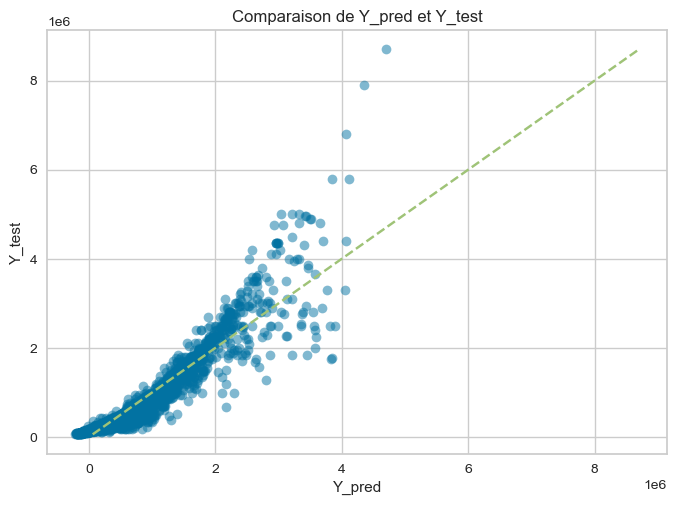

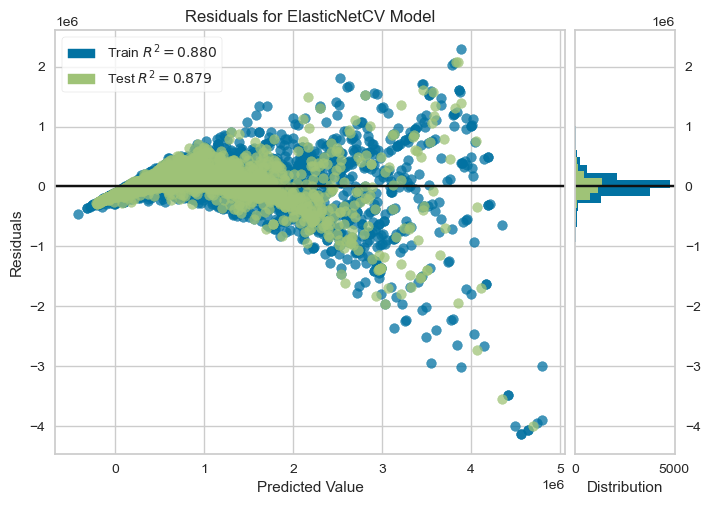

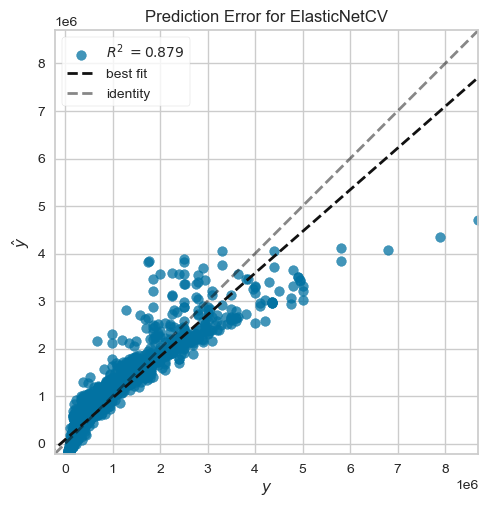

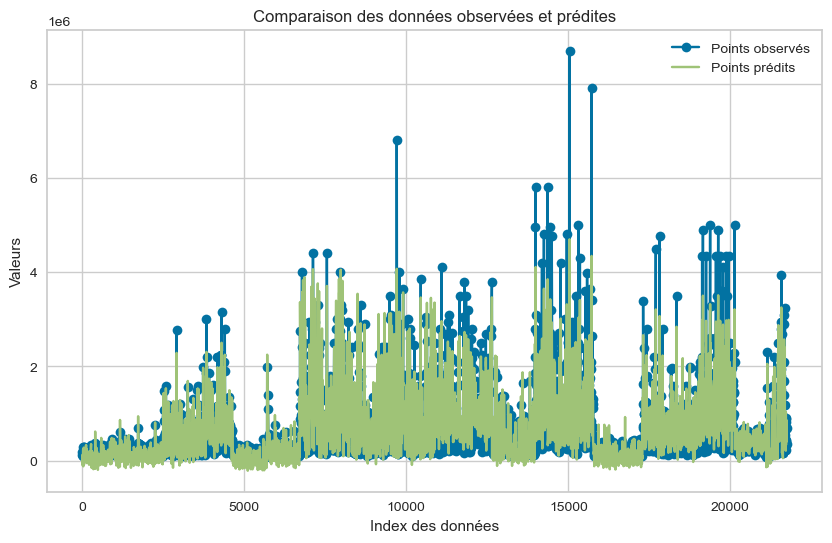

In [68]:
plt.plot(pred_test_s, y_test_s, 'o', alpha=0.5)
min_true = y_test_s.min()
max_true = y_test_s.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.show()

visualizer = ResidualsPlot(model_en_s)
visualizer.fit(X_train_s_scaled, y_train_s) 
visualizer.score(X_test_s_scaled, y_test_s) 
visualizer.show()                    

visualizer = PredictionError(model_en_s)
visualizer.fit(X_train_s_scaled, y_train_s)
visualizer.score(X_test_s_scaled, y_test_s)
visualizer.show()

donnees_comparatives_model_s = pd.DataFrame({'points_observés': y_test_s, 'points_predits': pred_test_s})
donnees_comparatives_model_s = donnees_comparatives_model_s.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_s.index, donnees_comparatives_model_s['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_s.index, donnees_comparatives_model_s['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()

Malgré des variables qui ne son pas multicolinéaires, le modèle n'a pas de meilleures performances que le précédent.  
Je vais à présent tester la régression polynomiale.

# Regression polynomiale à 2°

In [69]:
Xs_2 = df_annee[vif_data_list]
ys_2 = df_annee['prix_achat']

X_train_2,  X_test_2 , y_train_2,  y_test_2 = train_test_split(Xs_2, ys_2, test_size=0.2, random_state=42)
X_train_2 , X_val_2,  y_train_2,  y_val_2= train_test_split(X_train_2 , y_train_2 , test_size=0.2, random_state=42)

degree = 2  
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_2)
X_val_poly = poly.transform(X_val_2)
X_test_poly = poly.transform(X_test_2)

scaler_poly = RobustScaler()

X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

model_en_2= ElasticNetCV(
    cv=5, 
    l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
    alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
    max_iter=10000
)
model_en_2.fit(X_train_poly_scaled, y_train_2)

cv_scores = cross_val_score(model_en_2 , X_train_poly_scaled, y_train_2 , cv=3, verbose=2)

pred_train_2= model_en_2.predict(X_train_poly_scaled)
pred_val_2= model_en_2.predict(X_val_poly_scaled)
pred_test_2= model_en_2.predict(X_test_poly_scaled)

r2_train = model_en_2.score(X_train_poly_scaled, y_train_2)
r2_predict = model_en_2.score(X_test_poly_scaled, y_test_2)
MAE = mean_absolute_error(y_test_2 , pred_test_2)
MSE = mean_squared_error(y_test_2 , pred_test_2)
RMSE = np.sqrt(mean_squared_error(y_test_2,  pred_test_2))

print('R² train :', r2_train)
print('R² predict:', r2_predict)
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('Validation croisée scores :', cv_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   8.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] END .................................................... total time=   8.0s
[CV] END .................................................... total time=   8.6s
R² train : 0.9999979328084626
R² predict: 0.9999990632387263
MAE : 166.11994813284514
MSE : 492858.9618323308
RMSE : 702.0391455127917
Validation croisée scores : [0.99999907 0.99999545 0.9999989 ]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.1s finished


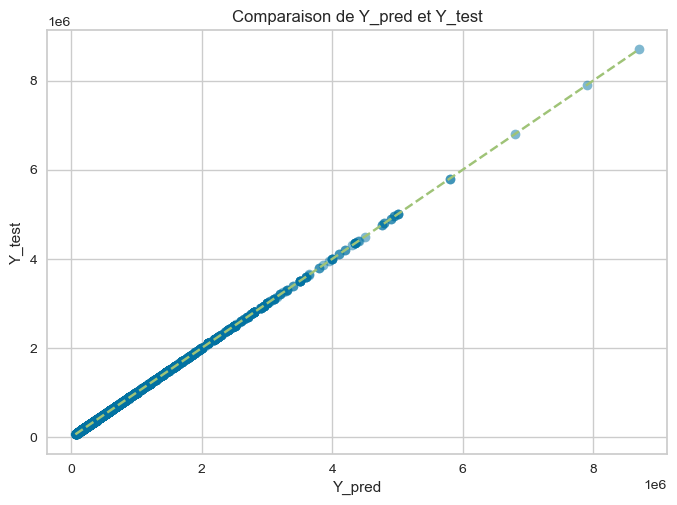

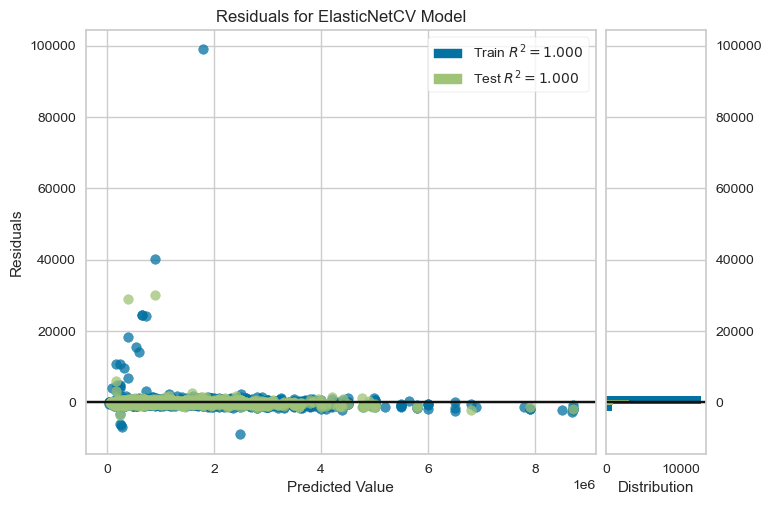

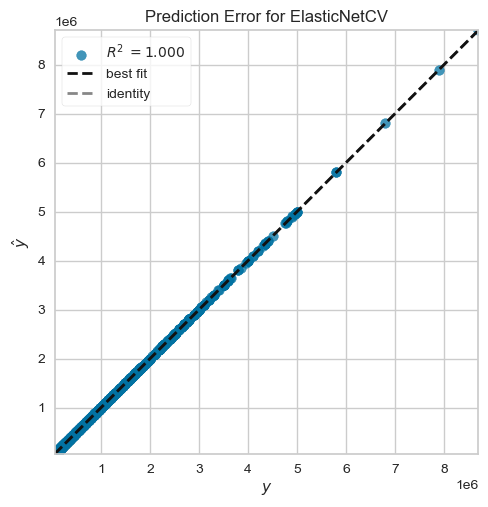

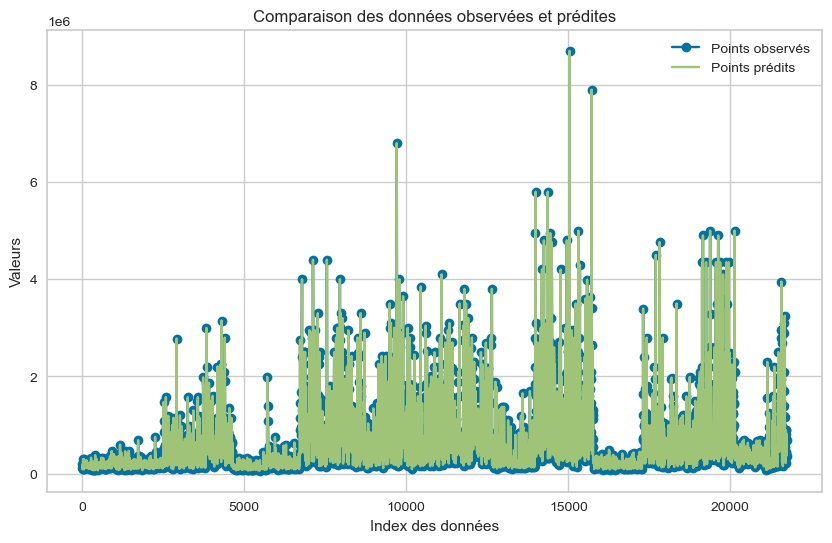

In [70]:
plt.plot(pred_test_2, y_test_2, 'o', alpha=0.5)
min_true = y_test_2.min()
max_true = y_test_2.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.show()

visualizer = ResidualsPlot(model_en_2)
visualizer.fit(X_train_poly_scaled, y_train_2)  
visualizer.score(X_test_poly_scaled, y_test_2)  
visualizer.show()                     

visualizer = PredictionError(model_en_2)
visualizer.fit(X_train_poly_scaled, y_train_2)
visualizer.score(X_test_poly_scaled, y_test_2)
visualizer.show()

donnees_comparatives_model_en_2 = pd.DataFrame({'points_observés': y_test_2, 'points_predits': pred_test_2})
donnees_comparatives_model_en_2 = donnees_comparatives_model_en_2.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_en_2.index, donnees_comparatives_model_en_2['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_en_2.index, donnees_comparatives_model_en_2['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()

Le modèle affiche un score très performant avec un RMSE de 702.

## Evaluation des modèles

Je vais d'abord choisir une ligne de mes données et la soumettre à nos différents modèles.

In [71]:
df.loc[(df['m2_construit']==110)&(df['prix_achat_m2']==3409),:]

,m2_construit,nb_pieces,prix_achat,prix_achat_m2,travaux_necessaire,jardin,piscine,terrace,balcon,salle_rangement,espace_vert,parking,num_quartier,type_appartement,type_duplex,type_maison,type_penthouse,nom_quartier
11484,110,3,375000,3409,True,False,False,False,False,False,False,False,6,True,False,False,False,Tetuan
14810,110,1,375000,3409,False,False,False,True,True,True,False,False,5,True,False,False,False,Chamartín
20437,110,1,375000,3409,False,False,False,True,False,False,False,True,1,False,False,False,True,Centro
21397,110,3,375000,3409,False,False,False,False,False,True,False,False,12,True,False,False,False,Usera


In [76]:
dico_test_modele = {'m2_construit':110,
                    'nb_pieces':1, 
                    'prix_achat_m2': 3409,
                    'travaux_necessaire': True, 
                    'jardin': False,
                    'piscine': False,
                    'terrace': False,
                    'balcon': False, 
                    'salle_rangement': False,
                    'espace_vert': False, 
                    'parking': False,
                    'num_quartier':6,
                    'type_appartement':True, 
                    'type_duplex': False, 
                    'type_maison': False,
                    'type_penthouse': False}
prix_achat = 375000

In [77]:
row_test = pd.DataFrame.from_dict(dico_test_modele,orient='index').T

In [78]:
# Test pour la regression logistique simple
nouvelle_observation = [[110]]
nouvelle_observation_scaled = scaler_reg.transform(nouvelle_observation)
prediction = regression.predict(nouvelle_observation_scaled)
print("Prédiction:", prediction)


Prédiction: [466397.31833079]


In [79]:
# Test pour la regression ElasticNetCV version 1
test_en = np.array(row_test)
test_scaled = scaler_en.transform(test_en)
prediction_en = model_en.predict(test_scaled)
print("Prédiction:", prediction_en)


Prédiction: [360678.50011779]


In [80]:
# Test pour la regression ElasticNetCV version 2
test_en_s = np.array(row_test[X_train_s.columns])
test_scaled_en_s = scaler_s.transform(test_en_s)
prediction_en_s = model_en_s.predict(test_scaled_en_s)
print("Prédiction:", prediction_en_s)


Prédiction: [393965.44817127]


In [81]:
# Test pour la regression polynomiale à 2°
test_poly = np.array(row_test[X_train_2.columns])
test_poly = poly.transform(test_poly)
test_scaled_poly = scaler_poly.transform(test_poly)
prediction_poly = model_en_2.predict(test_scaled_poly)
print("Prédiction:", prediction_poly)


Prédiction: [374975.9031503]


Le modèle polynomiale présente un excellent score. 

## Exportation du modèle sélectionné

In [85]:
filename = 'poly.pkl'
pickle.dump(poly, open(filename, 'wb'))

filename_1 = 'model_en_2.pkl'
pickle.dump(model_en_2, open(filename_1, 'wb'))

filename_2 = 'scaler.pkl'
pickle.dump(scaler_poly,open(filename_2, 'wb'))